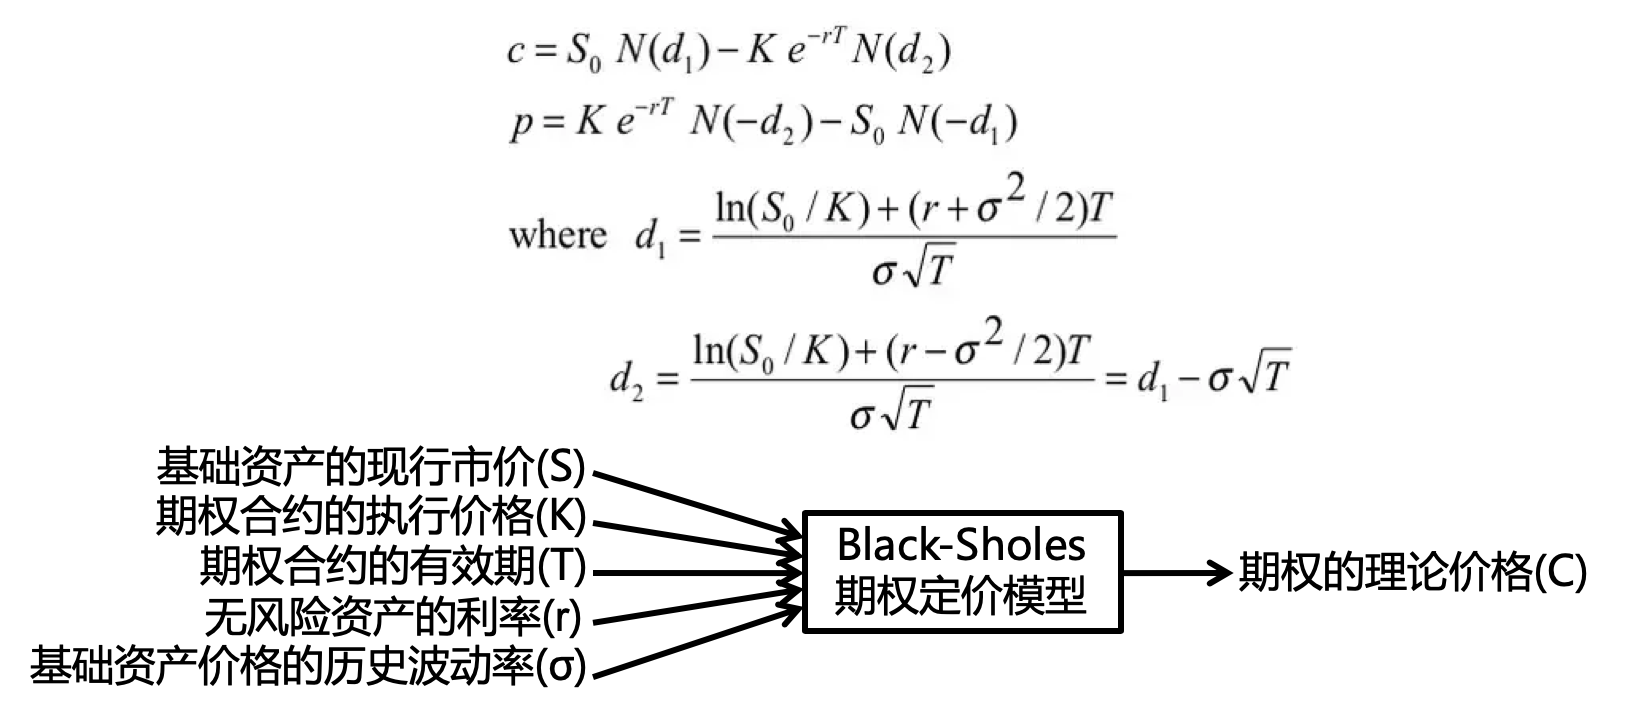

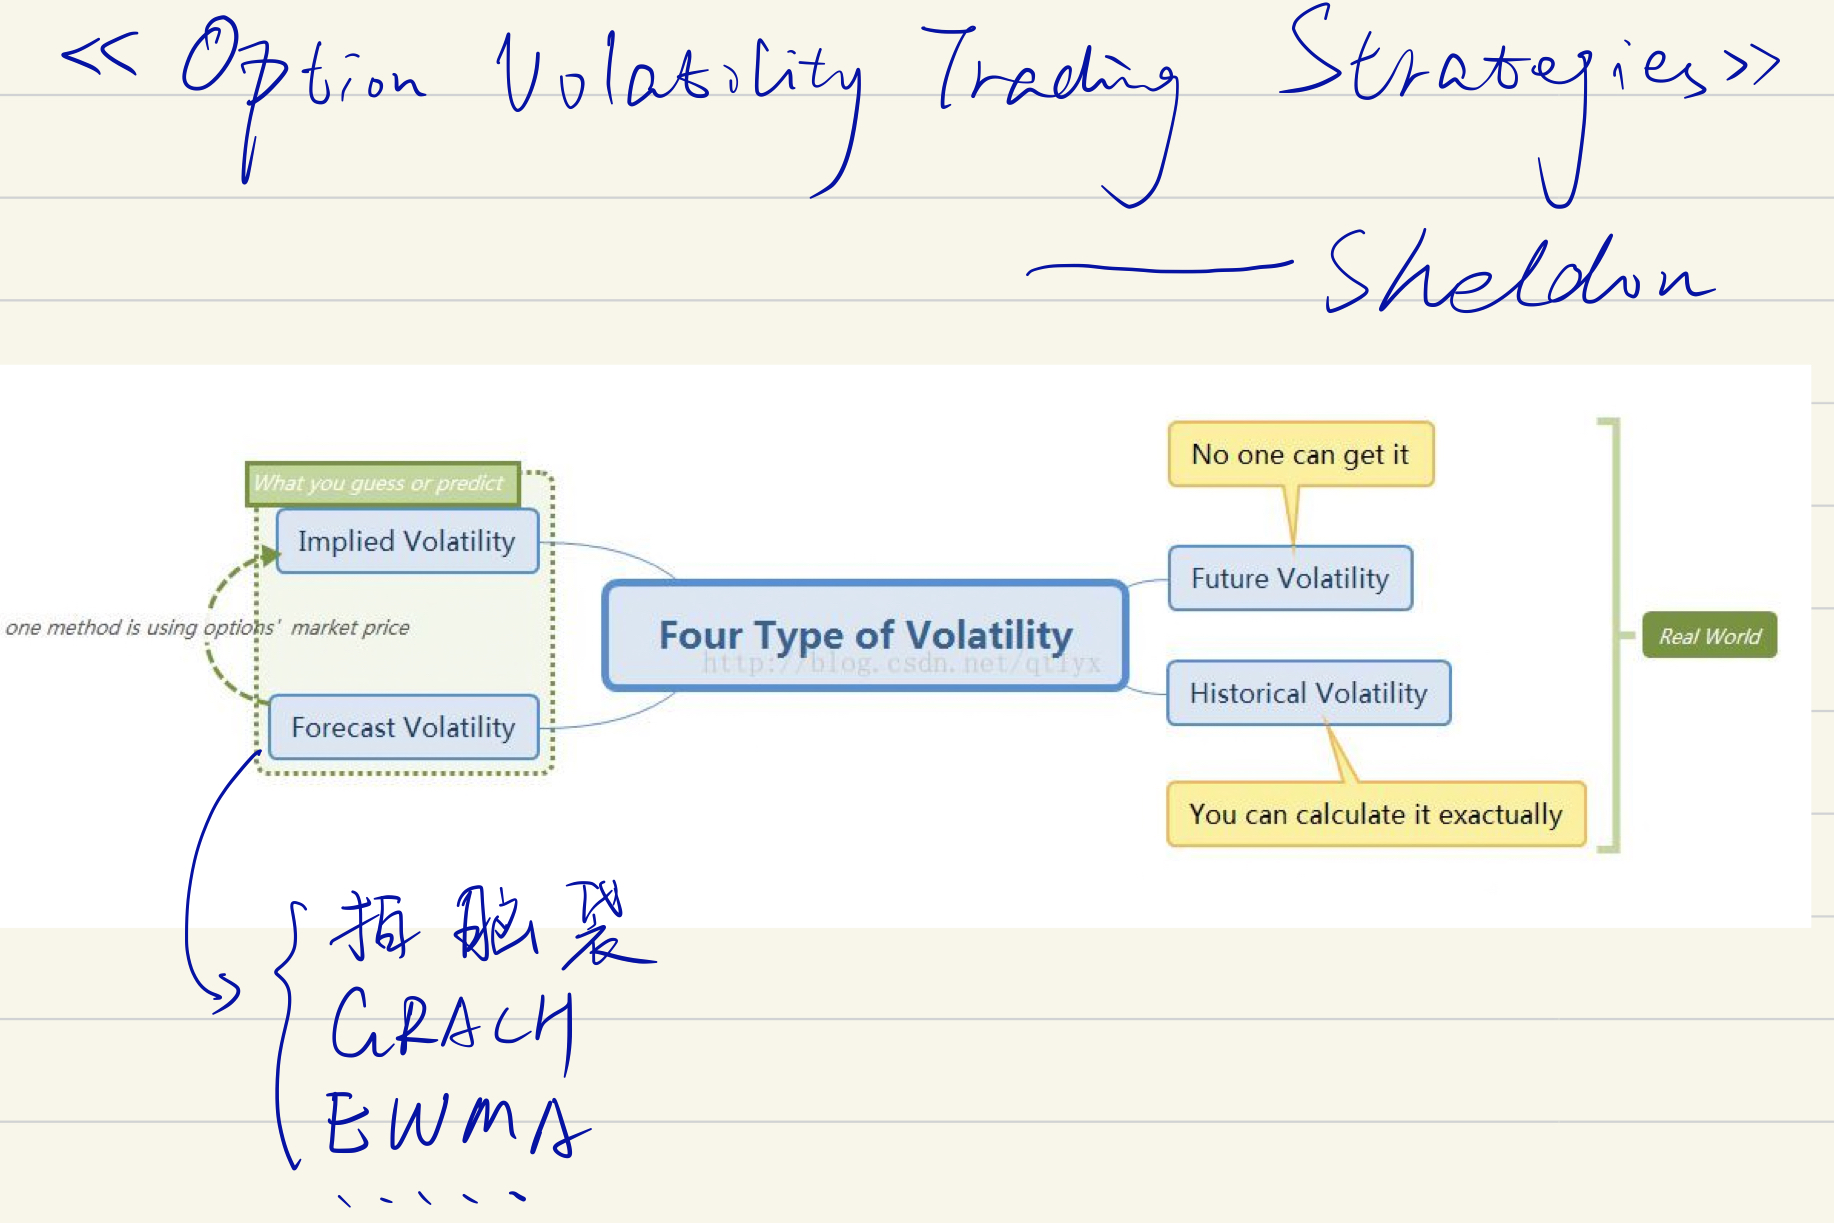

# Prepare

In [1]:
# import necessaries
import tushare as ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import tushare as ts
from datetime import datetime, timedelta
import time
from scipy import stats
from arch import arch_model


pro = ts.pro_api()
pd.set_option('display.max_rows', 1000)

# set plot conf
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# ignore warning
import warnings
warnings.filterwarnings("ignore")

# def draw_pic(data, title_name):
#     plt.figure(figsize=(12,8))
#     plt.plot(data)
#     plt.title(title_name)
#     plt.show()


def get_option_info(key_words_list):
    temp = pro.opt_basic(
        exchange='SSE',
        call_put='C',
        fields=
        'ts_code,name,exercise_price, list_date,delist_date,maturity_date')
    for i in key_words_list:
        temp = temp[temp['name'].str.contains(i)]
    return temp


def get_opiton_code(key_words_list):
    return str(get_option_info(key_words_list)['ts_code'].values[0])


def get_date_info(option_info):
    begin_date = str(option_info['list_date'].values[0])
    end_date = str(option_info['delist_date'].values[0])
    before_begin_date = datetime.strftime(
        datetime.strptime(begin_date, '%Y%m%d') - timedelta(days=DAYS_BEFORE),
        '%Y%m%d')
    return begin_date, end_date, before_begin_date


def col_to_date_and_as_index(df, col_name):
    df[col_name] = pd.to_datetime(df[col_name])
    df.index = df[col_name]


def get_option_trade_data(option_code):
    pro = ts.pro_api()
    option_trade = pro.opt_daily(ts_code=option_code)
    col_to_date_and_as_index(option_trade, 'trade_date')
    return option_trade.sort_index()


def get_underlying_asset_trade_data():
    pro = ts.pro_api()
    data = pro.fund_daily(
        ts_code='510050.SH', start_date=before_begin_date, end_date=end_date)
    col_to_date_and_as_index(data, 'trade_date')
    return data.sort_index()


def history_volatility(price_series, periods):
    volatility = pd.DataFrame(index=price_series.index)
    volatility['log_return'] = np.log(price_series) - np.log(
        price_series).shift(1)
    volatility['std'] = price_series.rolling(window=periods).std(
        ddof=1) * np.sqrt(250) / np.sqrt(periods)
    return volatility['std']


def get_risk_free_rate_data():
    #pro = ts.pro_api()
    df = pro.shibor(
        start_date=begin_date, end_date=end_date, fields='date,3m,1y')
    df['ccr'] = np.log(1 + df['1y'] / 100)
    col_to_date_and_as_index(df, 'date')
    return df


def d1(S0, K, r, sigma, T):
    return (np.log(S0 / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


def d2(S0, K, r, sigma, T):
    return (np.log(S0 / K) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))


def BlackScholes(option_type, S0, K, r, sigma, T):
    """
    S0  stock price
    K   strike price
    r   continuously compounded risk-free rate:
    sigma   volatility of the stock price per year
    T   time to maturity in trading years

    """
    if option_type == "C":
        return S0 * ss.norm.cdf(d1(S0, K, r, sigma, T)) - K * np.exp(
            -r * T) * ss.norm.cdf(d2(S0, K, r, sigma, T))
    else:
        return K * np.exp(-r * T) * ss.norm.cdf(-d2(
            S0, K, r, sigma, T)) - S0 * ss.norm.cdf(-d1(S0, K, r, sigma, T))

# Construct BS table

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def construct_BS_summary_table(key_words, vol_type = "hv", hv_periods=90):
    """
    key_words - list: key words of option
    volatility - Pandas series: sigma of the underlying asset trade data
    """
    global begin_date, end_date, before_begin_date, option_code, k
    
    option_info = get_option_info(key_words)
    option_code = get_opiton_code(key_words)
    begin_date, end_date, before_begin_date = get_date_info(option_info)
    option_trade = get_option_trade_data(option_code)
    underlying_asset_trade = get_underlying_asset_trade_data()
    risk_free_rate = get_risk_free_rate_data()

    k = option_info['exercise_price'].values[0]
    summary = pd.DataFrame(index=option_trade.index)
    summary['s'] = underlying_asset_trade['close']
    summary['t'] = (
        datetime.strptime(option_info['maturity_date'].values[0], "%Y%m%d") -
        underlying_asset_trade['trade_date']).dt.days / 365.0
    summary['r'] = risk_free_rate['ccr']
    
    summary['sigma'] = history_volatility(underlying_asset_trade['close'], hv_periods) 
    summary['bs_simulate'] = BlackScholes('C', summary['s'], k, summary['r'], summary['sigma'], summary['t'])
    summary['real_price'] = option_trade['close']
    summary = summary.dropna()
    print(mean_absolute_percentage_error(summary['bs_simulate'],summary['real_price']))
    return summary

In [3]:
DAYS_BEFORE = 500
key_words = ['1806', '2.651']
summary = construct_BS_summary_table(key_words)
summary

inf


s         t         r     sigma   bs_simulate  real_price
trade_date                                                               
2017-10-26  2.827  0.668493  0.043106  0.145026  2.907425e-01      0.2382
2017-10-27  2.873  0.665753  0.043103  0.143248  3.269769e-01      0.2613
2017-10-30  2.861  0.657534  0.043162  0.142318  3.152430e-01      0.2533
2017-10-31  2.851  0.654795  0.043228  0.140060  3.052917e-01      0.2519
2017-11-01  2.842  0.652055  0.043273  0.138332  2.964795e-01      0.2432
2017-11-02  2.847  0.649315  0.043334  0.137103  2.995627e-01      0.2468
2017-11-03  2.851  0.646575  0.043383  0.136484  3.021909e-01      0.2497
2017-11-06  2.843  0.638356  0.043408  0.135781  2.939250e-01      0.2376
2017-11-07  2.875  0.635616  0.043444  0.136284  3.207958e-01      0.2620
2017-11-08  2.874  0.632877  0.043464  0.135911  3.193641e-01      0.2674
2017-11-09  2.885  0.630137  0.043535  0.136309  3.286988e-01      0.2740
2017-11-10  2.918  0.627397  0.043608  0.137510  3.577607e-01      0.3047
2017-11-13  2.928  0.619178  0.043692  0.138208  3.658373e-01      0.3233
2017-11-14  2.913  0.616438  0.043804  0.136842  3.517065e-01      0.3140
2017-11-15  2.901  0.613699  0.044034  0.136543  3.409374e-01      0.3055
2017-11-16  2.932  0.610959  0.044430  0.137351  3.688421e-01      0.3300
2017-11-17  2.990  0.608219  0.044690  0.140370  4.225758e-01      0.3696
2017-11-20  2.996  0.600000  0.044734  0.143754  4.281408e-01      0.3814
2017-11-21  3.046  0.597260  0.044816  0.150439  4.763172e-01      0.4343
2017-11-22  3.067  0.594521  0.044882  0.157417  4.977468e-01      0.4642
2017-11-23  2.991  0.591781  0.044946  0.160957  4.292831e-01      0.3911
2017-11-24  2.990  0.589041  0.044991  0.164719  4.296162e-01      0.3999
2017-11-27  2.966  0.580822  0.045042  0.167339  4.083431e-01      0.3788
2017-11-28  2.896  0.578082  0.045105  0.167514  3.482499e-01      0.3663
2017-11-29  2.890  0.575342  0.045159  0.168216  3.432498e-01      0.3552
2017-11-30  2.858  0.572603  0.045251  0.168388  3.168598e-01      0.3338
2017-12-01  2.838  0.569863  0.045288  0.167787  3.001071e-01      0.3180
2017-12-04  2.858  0.561644  0.045339  0.167722  3.146166e-01      0.3178
2017-12-05  2.908  0.558904  0.045412  0.168230  3.557099e-01      0.3641
2017-12-06  2.871  0.556164  0.045438  0.167809  3.243490e-01      0.3408
2017-12-07  2.844  0.553425  0.045469  0.166962  3.016185e-01      0.3027
2017-12-08  2.865  0.550685  0.045511  0.166369  3.177457e-01      0.3236
2017-12-11  2.898  0.542466  0.045554  0.166293  3.435866e-01      0.3488
2017-12-12  2.846  0.539726  0.045596  0.166093  3.003751e-01      0.3199
2017-12-13  2.870  0.536986  0.045658  0.166194  3.194559e-01      0.3447
2017-12-14  2.850  0.534247  0.045797  0.165363  3.023942e-01      0.3222
2017-12-15  2.816  0.531507  0.045926  0.163849  2.741869e-01      0.2913
2017-12-18  2.828  0.523288  0.045900  0.162517  2.812989e-01      0.2949
2017-12-19  2.870  0.520548  0.045917  0.161572  3.143182e-01      0.3270
2017-12-20  2.876  0.517808  0.046138  0.160160  3.183226e-01      0.3301
2017-12-21  2.893  0.515068  0.046294  0.158631  3.315616e-01      0.3530
2017-12-22  2.878  0.512329  0.046396  0.155252  3.168472e-01      0.3459
2017-12-25  2.876  0.504110  0.046507  0.152468  3.125011e-01      0.3429
2017-12-26  2.893  0.501370  0.046531  0.150318  3.255929e-01      0.3659
2017-12-27  2.834  0.498630  0.046496  0.147038  2.737761e-01      0.3157
2017-12-28  2.855  0.495890  0.046511  0.144155  2.893480e-01      0.3279
2017-12-29  2.858  0.493151  0.046484  0.141572  2.901721e-01      0.3258
2018-01-02  2.907  0.482192  0.046378  0.139438  3.300530e-01      0.3571
2018-01-03  2.912  0.479452  0.046273  0.138110  3.334814e-01      0.3611
2018-01-04  2.919  0.476712  0.046202  0.137351  3.390007e-01      0.3596
2018-01-05  2.933  0.473973  0.046167  0.136475  3.509488e-01      0.3663
2018-01-08  2.944  0.465753  0.046120  0.137170  3.599267e-01      0.3760
2018-01-09  2.970  0

Text(0.5,1,"['1806', '2.651']")

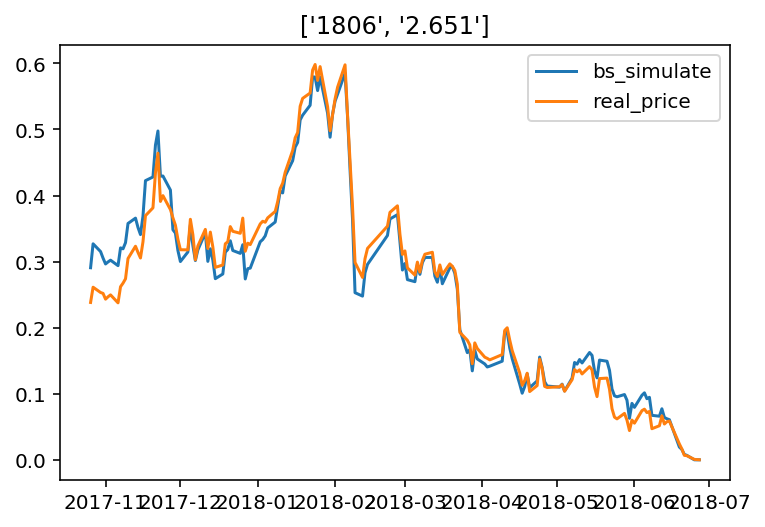

In [4]:
#plt.figure(figsize=(20,15))
plt.plot(summary['bs_simulate'], label = 'bs_simulate')
plt.plot(summary['real_price'], label = 'real_price')
plt.legend(loc = 'upper right')
plt.title(str(key_words))


inf


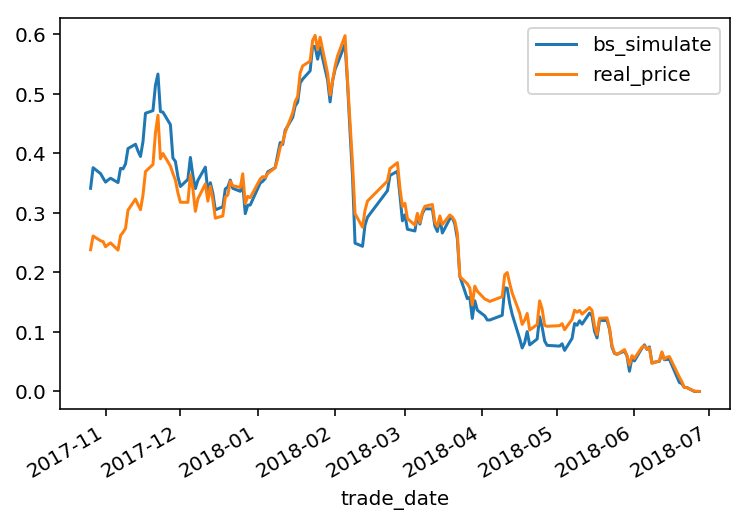

In [6]:
temp_150 = construct_BS_summary_table(key_words, hv_periods=150)
temp_150[['bs_simulate', 'real_price']].plot()
plt.legend()

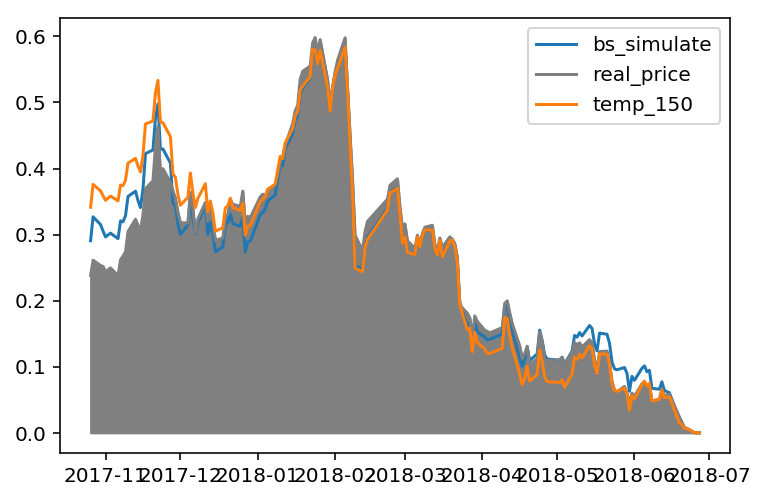

In [7]:
plt.plot(summary['bs_simulate'], label = 'bs_simulate')
plt.plot(summary['real_price'], label = 'real_price', color='grey')
plt.fill_between(summary.index, summary['real_price'], color='grey')

plt.plot(temp_150['bs_simulate'], label = 'temp_150')
plt.legend(loc = 'upper right')


In [8]:
summary

s         t         r     sigma   bs_simulate  real_price
trade_date                                                               
2017-10-26  2.827  0.668493  0.043106  0.145026  2.907425e-01      0.2382
2017-10-27  2.873  0.665753  0.043103  0.143248  3.269769e-01      0.2613
2017-10-30  2.861  0.657534  0.043162  0.142318  3.152430e-01      0.2533
2017-10-31  2.851  0.654795  0.043228  0.140060  3.052917e-01      0.2519
2017-11-01  2.842  0.652055  0.043273  0.138332  2.964795e-01      0.2432
2017-11-02  2.847  0.649315  0.043334  0.137103  2.995627e-01      0.2468
2017-11-03  2.851  0.646575  0.043383  0.136484  3.021909e-01      0.2497
2017-11-06  2.843  0.638356  0.043408  0.135781  2.939250e-01      0.2376
2017-11-07  2.875  0.635616  0.043444  0.136284  3.207958e-01      0.2620
2017-11-08  2.874  0.632877  0.043464  0.135911  3.193641e-01      0.2674
2017-11-09  2.885  0.630137  0.043535  0.136309  3.286988e-01      0.2740
2017-11-10  2.918  0.627397  0.043608  0.137510  3.577607e-01      0.3047
2017-11-13  2.928  0.619178  0.043692  0.138208  3.658373e-01      0.3233
2017-11-14  2.913  0.616438  0.043804  0.136842  3.517065e-01      0.3140
2017-11-15  2.901  0.613699  0.044034  0.136543  3.409374e-01      0.3055
2017-11-16  2.932  0.610959  0.044430  0.137351  3.688421e-01      0.3300
2017-11-17  2.990  0.608219  0.044690  0.140370  4.225758e-01      0.3696
2017-11-20  2.996  0.600000  0.044734  0.143754  4.281408e-01      0.3814
2017-11-21  3.046  0.597260  0.044816  0.150439  4.763172e-01      0.4343
2017-11-22  3.067  0.594521  0.044882  0.157417  4.977468e-01      0.4642
2017-11-23  2.991  0.591781  0.044946  0.160957  4.292831e-01      0.3911
2017-11-24  2.990  0.589041  0.044991  0.164719  4.296162e-01      0.3999
2017-11-27  2.966  0.580822  0.045042  0.167339  4.083431e-01      0.3788
2017-11-28  2.896  0.578082  0.045105  0.167514  3.482499e-01      0.3663
2017-11-29  2.890  0.575342  0.045159  0.168216  3.432498e-01      0.3552
2017-11-30  2.858  0.572603  0.045251  0.168388  3.168598e-01      0.3338
2017-12-01  2.838  0.569863  0.045288  0.167787  3.001071e-01      0.3180
2017-12-04  2.858  0.561644  0.045339  0.167722  3.146166e-01      0.3178
2017-12-05  2.908  0.558904  0.045412  0.168230  3.557099e-01      0.3641
2017-12-06  2.871  0.556164  0.045438  0.167809  3.243490e-01      0.3408
2017-12-07  2.844  0.553425  0.045469  0.166962  3.016185e-01      0.3027
2017-12-08  2.865  0.550685  0.045511  0.166369  3.177457e-01      0.3236
2017-12-11  2.898  0.542466  0.045554  0.166293  3.435866e-01      0.3488
2017-12-12  2.846  0.539726  0.045596  0.166093  3.003751e-01      0.3199
2017-12-13  2.870  0.536986  0.045658  0.166194  3.194559e-01      0.3447
2017-12-14  2.850  0.534247  0.045797  0.165363  3.023942e-01      0.3222
2017-12-15  2.816  0.531507  0.045926  0.163849  2.741869e-01      0.2913
2017-12-18  2.828  0.523288  0.045900  0.162517  2.812989e-01      0.2949
2017-12-19  2.870  0.520548  0.045917  0.161572  3.143182e-01      0.3270
2017-12-20  2.876  0.517808  0.046138  0.160160  3.183226e-01      0.3301
2017-12-21  2.893  0.515068  0.046294  0.158631  3.315616e-01      0.3530
2017-12-22  2.878  0.512329  0.046396  0.155252  3.168472e-01      0.3459
2017-12-25  2.876  0.504110  0.046507  0.152468  3.125011e-01      0.3429
2017-12-26  2.893  0.501370  0.046531  0.150318  3.255929e-01      0.3659
2017-12-27  2.834  0.498630  0.046496  0.147038  2.737761e-01      0.3157
2017-12-28  2.855  0.495890  0.046511  0.144155  2.893480e-01      0.3279
2017-12-29  2.858  0.493151  0.046484  0.141572  2.901721e-01      0.3258
2018-01-02  2.907  0.482192  0.046378  0.139438  3.300530e-01      0.3571
2018-01-03  2.912  0.479452  0.046273  0.138110  3.334814e-01      0.3611
2018-01-04  2.919  0.476712  0.046202  0.137351  3.390007e-01      0.3596
2018-01-05  2.933  0.473973  0.046167  0.136475  3.509488e-01      0.3663
2018-01-08  2.944  0.465753  0.046120  0.137170  3.599267e-01      0.3760
2018-01-09  2.970  0

In [9]:
mean_absolute_percentage_error(summary['bs_simulate'],summary['real_price'])

inf

# History Vol

In [10]:
underlying_asset_trade = get_underlying_asset_trade_data()

underlying_asset_trade

ts_code trade_date  pre_close   open   high    low  close  \
trade_date                                                                
2016-06-13  510050.SH 2016-06-13      2.139  2.123  2.126  2.087  2.088   
2016-06-14  510050.SH 2016-06-14      2.088  2.087  2.104  2.086  2.101   
2016-06-15  510050.SH 2016-06-15      2.101  2.080  2.122  2.077  2.109   
2016-06-16  510050.SH 2016-06-16      2.109  2.100  2.110  2.097  2.102   
2016-06-17  510050.SH 2016-06-17      2.102  2.107  2.125  2.106  2.109   
2016-06-20  510050.SH 2016-06-20      2.109  2.115  2.118  2.102  2.114   
2016-06-21  510050.SH 2016-06-21      2.114  2.119  2.141  2.110  2.112   
2016-06-22  510050.SH 2016-06-22      2.112  2.110  2.126  2.106  2.124   
2016-06-23  510050.SH 2016-06-23      2.124  2.126  2.127  2.107  2.116   
2016-06-24  510050.SH 2016-06-24      2.116  2.113  2.127  2.068  2.090   
2016-06-27  510050.SH 2016-06-27      2.090  2.090  2.112  2.087  2.111   
2016-06-28  510050.SH 2016-06-28      2.111  2.106  2.119  2.098  2.117   
2016-06-29  510050.SH 2016-06-29      2.117  2.119  2.138  2.119  2.135   
2016-06-30  510050.SH 2016-06-30      2.135  2.140  2.146  2.136  2.136   
2016-07-01  510050.SH 2016-07-01      2.136  2.142  2.149  2.141  2.142   
2016-07-04  510050.SH 2016-07-04      2.142  2.141  2.186  2.137  2.177   
2016-07-05  510050.SH 2016-07-05      2.177  2.175  2.193  2.175  2.185   
2016-07-06  510050.SH 2016-07-06      2.185  2.177  2.186  2.167  2.184   
2016-07-07  510050.SH 2016-07-07      2.184  2.182  2.196  2.174  2.189   
2016-07-08  510050.SH 2016-07-08      2.189  2.184  2.187  2.176  2.177   
2016-07-11  510050.SH 2016-07-11      2.177  2.181  2.208  2.181  2.188   
2016-07-12  510050.SH 2016-07-12      2.188  2.188  2.235  2.188  2.233   
2016-07-13  510050.SH 2016-07-13      2.233  2.237  2.266  2.233  2.236   
2016-07-14  510050.SH 2016-07-14      2.236  2.237  2.239  2.220  2.233   
2016-07-15  510050.SH 2016-07-15      2.233  2.235  2.242  2.227  2.236   
2016-07-18  510050.SH 2016-07-18      2.236  2.235  2.247  2.227  2.228   
2016-07-19  510050.SH 2016-07-19      2.228  2.226  2.235  2.205  2.216   
2016-07-20  510050.SH 2016-07-20      2.216  2.216  2.222  2.207  2.209   
2016-07-21  510050.SH 2016-07-21      2.209  2.211  2.228  2.211  2.220   
2016-07-22  510050.SH 2016-07-22      2.220  2.218  2.222  2.199  2.200   
2016-07-25  510050.SH 2016-07-25      2.200  2.199  2.210  2.197  2.201   
2016-07-26  510050.SH 2016-07-26      2.201  2.201  2.229  2.197  2.227   
2016-07-27  510050.SH 2016-07-27      2.227  2.228  2.232  2.172  2.215   
2016-07-28  510050.SH 2016-07-28      2.215  2.203  2.218  2.193  2.211   
2016-07-29  510050.SH 2016-07-29      2.211  2.209  2.212  2.195  2.201   
2016-08-01  510050.SH 2016-08-01      2.201  2.199  2.200  2.182  2.190   
2016-08-02  510050.SH 2016-08-02      2.190  2.191  2.198  2.182  2.190   
2016-08-03  510050.SH 2016-08-03      2.190  2.188  2.193  2.181  2.188   
2016-08-04  510050.SH 2016-08-04      2.188  2.187  2.189  2.172  2.186   
2016-08-05  510050.SH 2016-08-05      2.186  2.186  2.205  2.181  2.195   
2016-08-08  510050.SH 2016-08-08      2.195  2.196  2.206  2.185  2.204   
2016-08-09  510050.SH 2016-08-09      2.204  2.201  2.223  2.201  2.221   
2016-08-10  510050.SH 2016-08-10      2.221  2.222  2.223  2.213  2.216   
2016-08-11  510050.SH 2016-08-11      2.216  2.216  2.256  2.212  2.223   
2016-08-12  510050.SH 2016-08-12      2.223  2.223  2.273  2.222  2.272   
2016-08-15  510050.SH 2016-08-15      2.272  2.276  2.368  2.273  2.336   
2016-08-16  510050.SH 2016-08-16      2.336  2.340  2.352  2.304  2.306   
2016-08-17  510050.SH 2016-08-17      2.306  2.308  2.321  2.291  2.300   
2016-08-18  510050.SH 2016-08-18      2.300  2.301  2.322  2.283  2.290   
2016-08-19  510050.SH 2016-08-19      2.290  2.289  2.305  2.281  2.301   
2016-08-22  510050.SH 2016-08-22      2.301  2.300  2.304  2.283  2.287   
2016-08-23  510050.SH 2016-08-23      2

In [11]:
def history_volatility(price_series, periods):
    volatility = pd.DataFrame(index=price_series.index)
    volatility['log_return'] = np.log(price_series) - np.log(
        price_series).shift(1)
    volatility['std'] = price_series.rolling(window=periods).std(
        ddof=1) * np.sqrt(250) / np.sqrt(periods)
    return volatility['std']


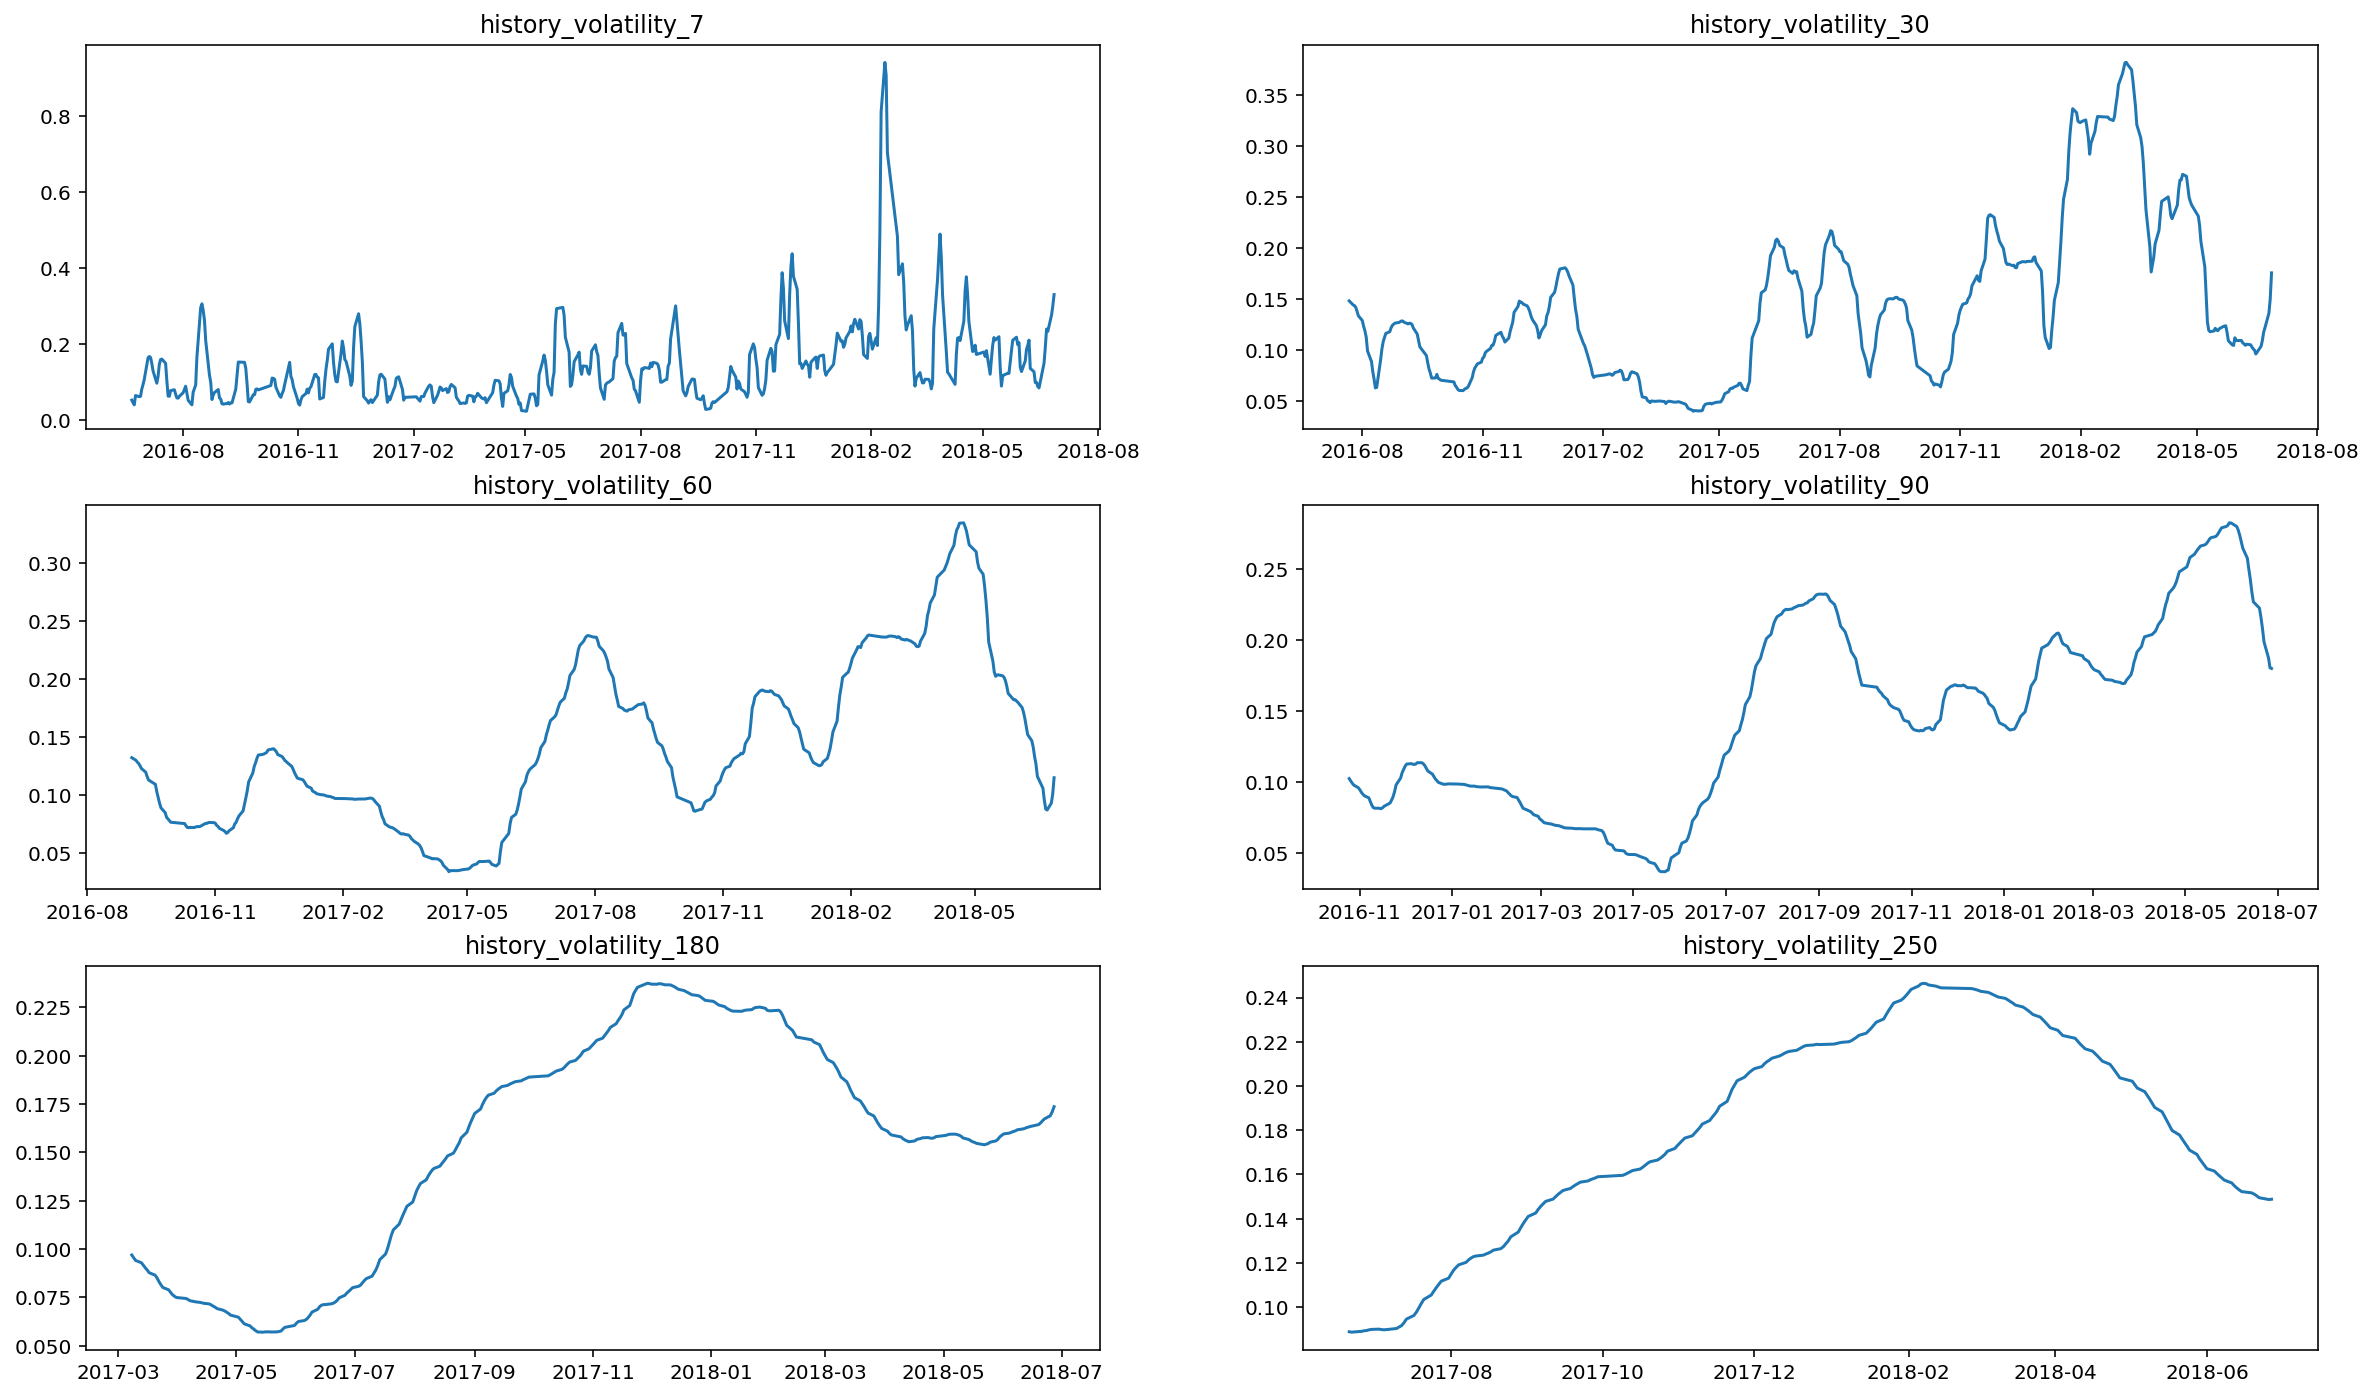

In [12]:
peiords_list = [7, 30, 60, 90, 180, 250]
col = 3
rows = 2

plt.figure(figsize=(20,12))
for i in range(0, 6):
    plt.subplot(3,2,i+1)
    plt.plot(history_volatility(underlying_asset_trade['close'], peiords_list[i]))
    plt.title('history_volatility_'+ str(peiords_list[i]))
    


In [13]:
summary['HV30'] = history_volatility(underlying_asset_trade['close'], 30)
summary['HV60'] = history_volatility(underlying_asset_trade['close'], 60)
summary['HV90'] = history_volatility(underlying_asset_trade['close'], 90)
summary['HV120'] = history_volatility(underlying_asset_trade['close'], 120)
summary['HV150'] = history_volatility(underlying_asset_trade['close'], 150)
summary['HV180'] = history_volatility(underlying_asset_trade['close'], 180)
summary['HV210'] = history_volatility(underlying_asset_trade['close'], 210)
summary['HV250'] = history_volatility(underlying_asset_trade['close'], 250)

summary

s         t         r     sigma   bs_simulate  real_price  \
trade_date                                                                  
2017-10-26  2.827  0.668493  0.043106  0.145026  2.907425e-01      0.2382   
2017-10-27  2.873  0.665753  0.043103  0.143248  3.269769e-01      0.2613   
2017-10-30  2.861  0.657534  0.043162  0.142318  3.152430e-01      0.2533   
2017-10-31  2.851  0.654795  0.043228  0.140060  3.052917e-01      0.2519   
2017-11-01  2.842  0.652055  0.043273  0.138332  2.964795e-01      0.2432   
2017-11-02  2.847  0.649315  0.043334  0.137103  2.995627e-01      0.2468   
2017-11-03  2.851  0.646575  0.043383  0.136484  3.021909e-01      0.2497   
2017-11-06  2.843  0.638356  0.043408  0.135781  2.939250e-01      0.2376   
2017-11-07  2.875  0.635616  0.043444  0.136284  3.207958e-01      0.2620   
2017-11-08  2.874  0.632877  0.043464  0.135911  3.193641e-01      0.2674   
2017-11-09  2.885  0.630137  0.043535  0.136309  3.286988e-01      0.2740   
2017-11-10  2.918  0.627397  0.043608  0.137510  3.577607e-01      0.3047   
2017-11-13  2.928  0.619178  0.043692  0.138208  3.658373e-01      0.3233   
2017-11-14  2.913  0.616438  0.043804  0.136842  3.517065e-01      0.3140   
2017-11-15  2.901  0.613699  0.044034  0.136543  3.409374e-01      0.3055   
2017-11-16  2.932  0.610959  0.044430  0.137351  3.688421e-01      0.3300   
2017-11-17  2.990  0.608219  0.044690  0.140370  4.225758e-01      0.3696   
2017-11-20  2.996  0.600000  0.044734  0.143754  4.281408e-01      0.3814   
2017-11-21  3.046  0.597260  0.044816  0.150439  4.763172e-01      0.4343   
2017-11-22  3.067  0.594521  0.044882  0.157417  4.977468e-01      0.4642   
2017-11-23  2.991  0.591781  0.044946  0.160957  4.292831e-01      0.3911   
2017-11-24  2.990  0.589041  0.044991  0.164719  4.296162e-01      0.3999   
2017-11-27  2.966  0.580822  0.045042  0.167339  4.083431e-01      0.3788   
2017-11-28  2.896  0.578082  0.045105  0.167514  3.482499e-01      0.3663   
2017-11-29  2.890  0.575342  0.045159  0.168216  3.432498e-01      0.3552   
2017-11-30  2.858  0.572603  0.045251  0.168388  3.168598e-01      0.3338   
2017-12-01  2.838  0.569863  0.045288  0.167787  3.001071e-01      0.3180   
2017-12-04  2.858  0.561644  0.045339  0.167722  3.146166e-01      0.3178   
2017-12-05  2.908  0.558904  0.045412  0.168230  3.557099e-01      0.3641   
2017-12-06  2.871  0.556164  0.045438  0.167809  3.243490e-01      0.3408   
2017-12-07  2.844  0.553425  0.045469  0.166962  3.016185e-01      0.3027   
2017-12-08  2.865  0.550685  0.045511  0.166369  3.177457e-01      0.3236   
2017-12-11  2.898  0.542466  0.045554  0.166293  3.435866e-01      0.3488   
2017-12-12  2.846  0.539726  0.045596  0.166093  3.003751e-01      0.3199   
2017-12-13  2.870  0.536986  0.045658  0.166194  3.194559e-01      0.3447   
2017-12-14  2.850  0.534247  0.045797  0.165363  3.023942e-01      0.3222   
2017-12-15  2.816  0.531507  0.045926  0.163849  2.741869e-01      0.2913   
2017-12-18  2.828  0.523288  0.045900  0.162517  2.812989e-01      0.2949   
2017-12-19  2.870  0.520548  0.045917  0.161572  3.143182e-01      0.3270   
2017-12-20  2.876  0.517808  0.046138  0.160160  3.183226e-01      0.3301   
2017-12-21  2.893  0.515068  0.046294  0.158631  3.315616e-01      0.3530   
2017-12-22  2.878  0.512329  0.046396  0.155252  3.168472e-01      0.3459   
2017-12-25  2.876  0.504110  0.046507  0.152468  3.125011e-01      0.3429   
2017-12-26  2.893  0.501370  0.046531  0.150318  3.255929e-01      0.3659   
2017-12-27  2.834  0.498630  0.046496  0.147038  2.737761e-01      0.3157   
2017-12-28  2.855  0.495890  0.046511  0.144155  2.893480e-01      0.3279   
2017-12-29  2.858  0.493151  0.046484  0.141572  2.901721e-01      0.3258   
2018-01-02  2.907  0.482192  0.046378  0.139438  3.300530e-01      0.3571   
2018-01-03  2.912  0.479452  0.046273  0.138110  3.334814e-01      0.3611   
2018-01-04  2.919  0.476712  0.046202  0.137351  3.390007e-01      0.3596   
2018-01-05  

# Implied Vol

## Theory

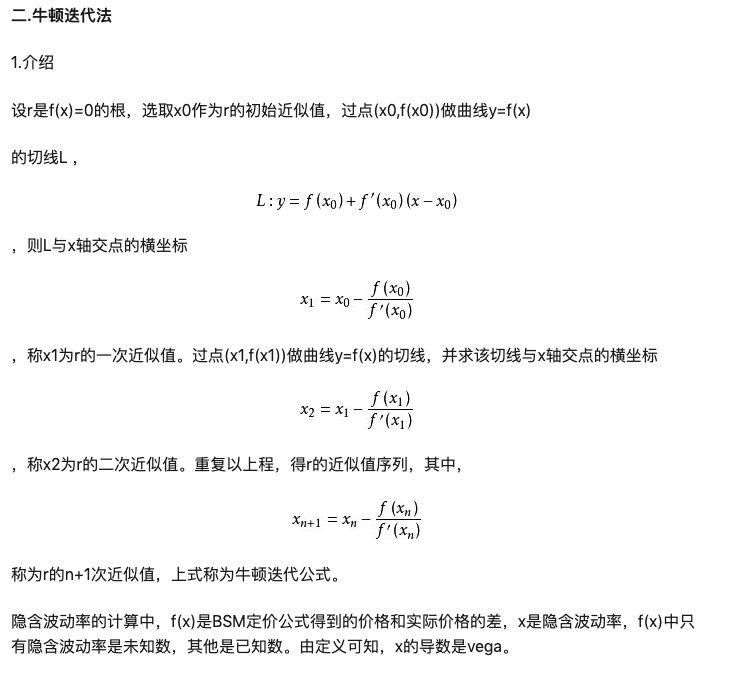

![Newton's method](https://upload.wikimedia.org/wikipedia/commons/e/e0/NewtonIteration_Ani.gif)

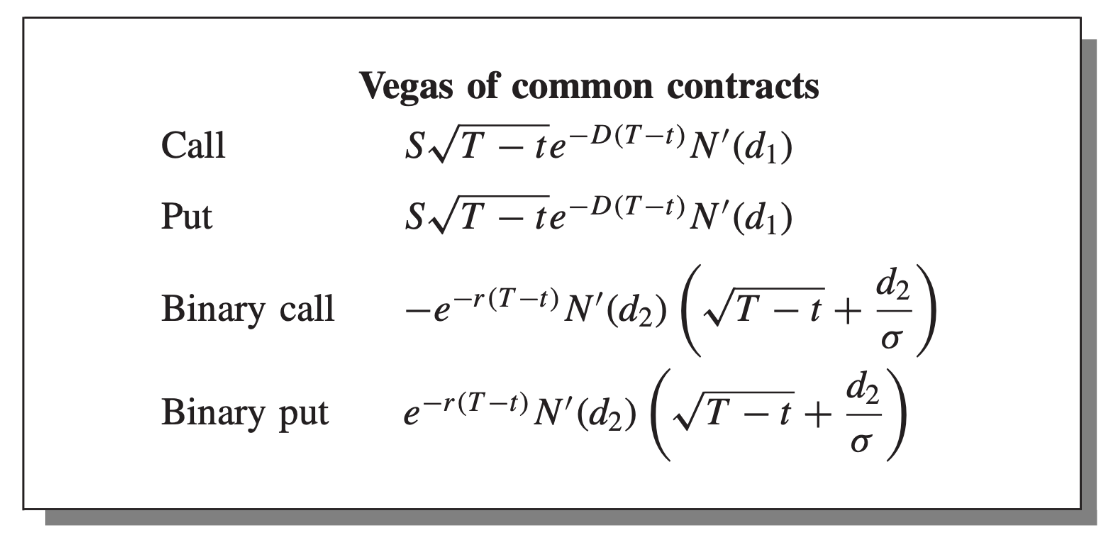

## Code

In [14]:
def bs_vega(option_type, S0, K, r, sigma, T):  # -dPi/dSigma
    # d1 = d1(S0, K, r, sigma, T)
    return S0 * np.sqrt(T) * ss.norm.pdf(d1(S0, K, r, sigma, T))


def implied_vol(option_type, S0, K, r, T, real_price):
    # f(x) = BSF(x) - real_price
    # x -> sigma

    def f(sigma):
        return BlackScholes(option_type, S0, K, r, sigma, T) - real_price

    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5

    sigma = 0.2
    count = 0

    while abs(f(sigma)) > PRECISION:
        vega = bs_vega(option_type, S0, K, r, sigma, T)
        
        sigma = sigma - (f(sigma) / (vega)) #f/f'
        count += 1
        if count > 100: break
    return sigma

# option_type, S0, K, r, T, real_price
for index, rows in summary.iterrows():
    summary.loc[index, 'IV'] = implied_vol(
        'C', rows['s'], k, rows['r'], rows['t'], rows['real_price'])    
summary = summary.replace([np.inf, -np.inf], np.nan).dropna()

summary

s         t         r     sigma  bs_simulate  real_price  \
trade_date                                                                 
2017-10-30  2.861  0.657534  0.043162  0.142318     0.315243      0.2533   
2017-11-28  2.896  0.578082  0.045105  0.167514     0.348250      0.3663   
2017-11-29  2.890  0.575342  0.045159  0.168216     0.343250      0.3552   
2017-11-30  2.858  0.572603  0.045251  0.168388     0.316860      0.3338   
2017-12-01  2.838  0.569863  0.045288  0.167787     0.300107      0.3180   
2017-12-04  2.858  0.561644  0.045339  0.167722     0.314617      0.3178   
2017-12-05  2.908  0.558904  0.045412  0.168230     0.355710      0.3641   
2017-12-06  2.871  0.556164  0.045438  0.167809     0.324349      0.3408   
2017-12-07  2.844  0.553425  0.045469  0.166962     0.301619      0.3027   
2017-12-08  2.865  0.550685  0.045511  0.166369     0.317746      0.3236   
2017-12-11  2.898  0.542466  0.045554  0.166293     0.343587      0.3488   
2017-12-12  2.846  0.539726  0.045596  0.166093     0.300375      0.3199   
2017-12-13  2.870  0.536986  0.045658  0.166194     0.319456      0.3447   
2017-12-14  2.850  0.534247  0.045797  0.165363     0.302394      0.3222   
2017-12-15  2.816  0.531507  0.045926  0.163849     0.274187      0.2913   
2017-12-18  2.828  0.523288  0.045900  0.162517     0.281299      0.2949   
2017-12-19  2.870  0.520548  0.045917  0.161572     0.314318      0.3270   
2017-12-20  2.876  0.517808  0.046138  0.160160     0.318323      0.3301   
2017-12-21  2.893  0.515068  0.046294  0.158631     0.331562      0.3530   
2017-12-22  2.878  0.512329  0.046396  0.155252     0.316847      0.3459   
2017-12-25  2.876  0.504110  0.046507  0.152468     0.312501      0.3429   
2017-12-26  2.893  0.501370  0.046531  0.150318     0.325593      0.3659   
2017-12-27  2.834  0.498630  0.046496  0.147038     0.273776      0.3157   
2017-12-28  2.855  0.495890  0.046511  0.144155     0.289348      0.3279   
2017-12-29  2.858  0.493151  0.046484  0.141572     0.290172      0.3258   
2018-01-02  2.907  0.482192  0.046378  0.139438     0.330053      0.3571   
2018-01-03  2.912  0.479452  0.046273  0.138110     0.333481      0.3611   
2018-01-04  2.919  0.476712  0.046202  0.137351     0.339001      0.3596   
2018-01-05  2.933  0.473973  0.046167  0.136475     0.350949      0.3663   
2018-01-08  2.944  0.465753  0.046120  0.137170     0.359927      0.3760   
2018-01-09  2.970  0.463014  0.046120  0.138928     0.384051      0.3909   
2018-01-10  2.994  0.460274  0.046120  0.141353     0.406687      0.4105   
2018-01-11  2.991  0.457534  0.046149  0.143339     0.404002      0.4188   
2018-01-12  3.018  0.454795  0.046151  0.145984     0.429592      0.4352   
2018-01-15  3.043  0.446575  0.046171  0.149285     0.452782      0.4682   
2018-01-16  3.064  0.443836  0.046212  0.153273     0.473217      0.4874   
2018-01-17  3.071  0.441096  0.046235  0.157548     0.480372      0.4955   
2018-01-18  3.106  0.438356  0.046246  0.162790     0.514396      0.5352   
2018-01-19  3.113  0.435616  0.046296  0.167524     0.521640      0.5471   
2018-01-22  3.129  0.427397  0.046339  0.172475     0.536681      0.5552   
2018-01-23  3.173  0.424658  0.046333  0.178954     0.579619      0.5900   
2018-01-24  3.172  0.421918  0.046333  0.185162     0.579364      0.5984   
2018-01-25  3.150  0.419178  0.046333  0.189670     0.558894      0.5743   
2018-01-26  3.171  0.416438  0.046333  0.194275     0.579365      0.5952   
2018-01-29  3.114  0.408219  0.046333  0.196150     0.524746      0.5345   
2018-01-30  3.075  0.405479  0.046333  0.196689     0.488296      0.4981   
2018-01-31  3.113  0.402740  0.046333  0.197945     0.523330      0.5217   
2018-02-01  3.134  0.400000  0.046371  0.199563     0.542932      0.5463   
2018-02-02  3.145  0.397260  0.046365  0.201579     0.553267      0.5640   
2018-02-05  3.180  0.389041  0.046355  0.204646     0.585596      0.5979   
2018-02-06  3.110  0.386301  0.046373  0.204915     0.519501    

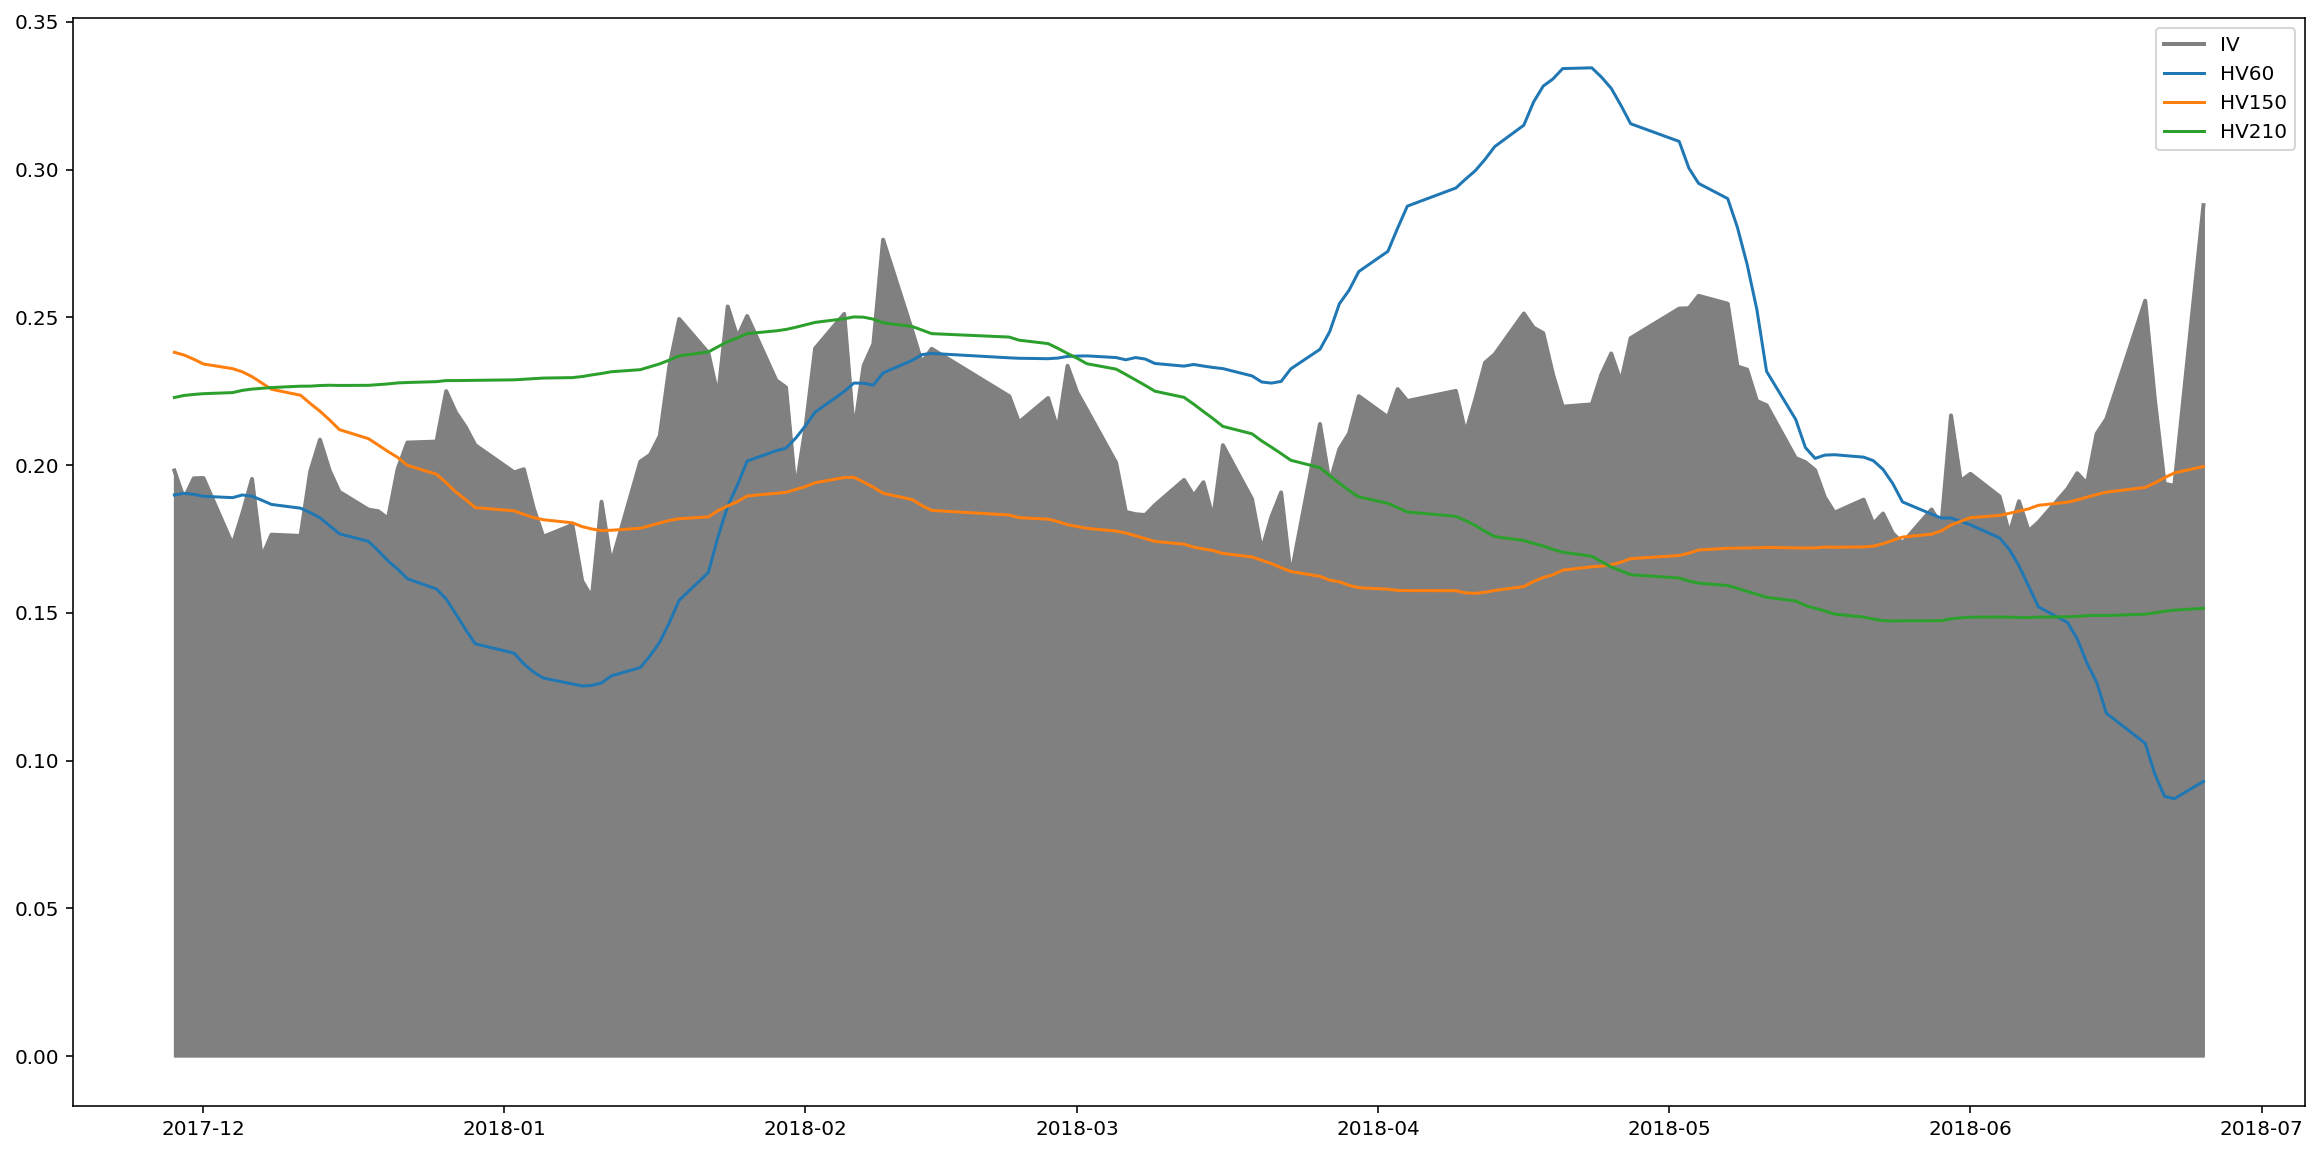

In [15]:
summary = summary.iloc[1:,]
plt.figure(figsize=(20,10))
plt.plot(summary['IV'], label = 'IV',linewidth=2,color='grey')
plt.fill_between(summary.index, summary['IV'], color='grey')
#plt.plot(summary['HV30'], label = 'HV30')
plt.plot(summary['HV60'], label = 'HV60')
#plt.plot(summary['HV90'], label = 'HV90')
#plt.plot(summary['HV120'], label = 'HV120')
plt.plot(summary['HV150'], label = 'HV150')
plt.plot(summary['HV210'], label = 'HV210')

#plt.plot(summary['HV250'], label = 'HV250')

plt.legend()

In [16]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
for i in ['HV60','HV150','HV210']:
    print(i)
    print(mean_absolute_percentage_error(summary['IV'],summary[i]))

HV60
20.393305532871977
HV150
16.0959309464385
HV210
18.73329714033205


In [18]:
for i in ['HV30','HV60','HV90','HV120','HV150','HV180','HV210','HV250']:
    print(i)
    print(mean_absolute_percentage_error(summary['IV'],summary[i]))

HV30
31.429292728754444
HV60
20.393305532871977
HV90
19.013563473556964
HV120
16.62626610467196
HV150
16.0959309464385
HV180
18.476636849247726
HV210
18.73329714033205
HV250
13.734962055055163


In [19]:
bs_60 = BlackScholes('C', summary['s'], k, summary['r'], summary['HV60'], summary['t'])
bs_150 = BlackScholes('C', summary['s'], k, summary['r'], summary['HV150'], summary['t'])
bs_210 = BlackScholes('C', summary['s'], k, summary['r'], summary['HV210'], summary['t'])


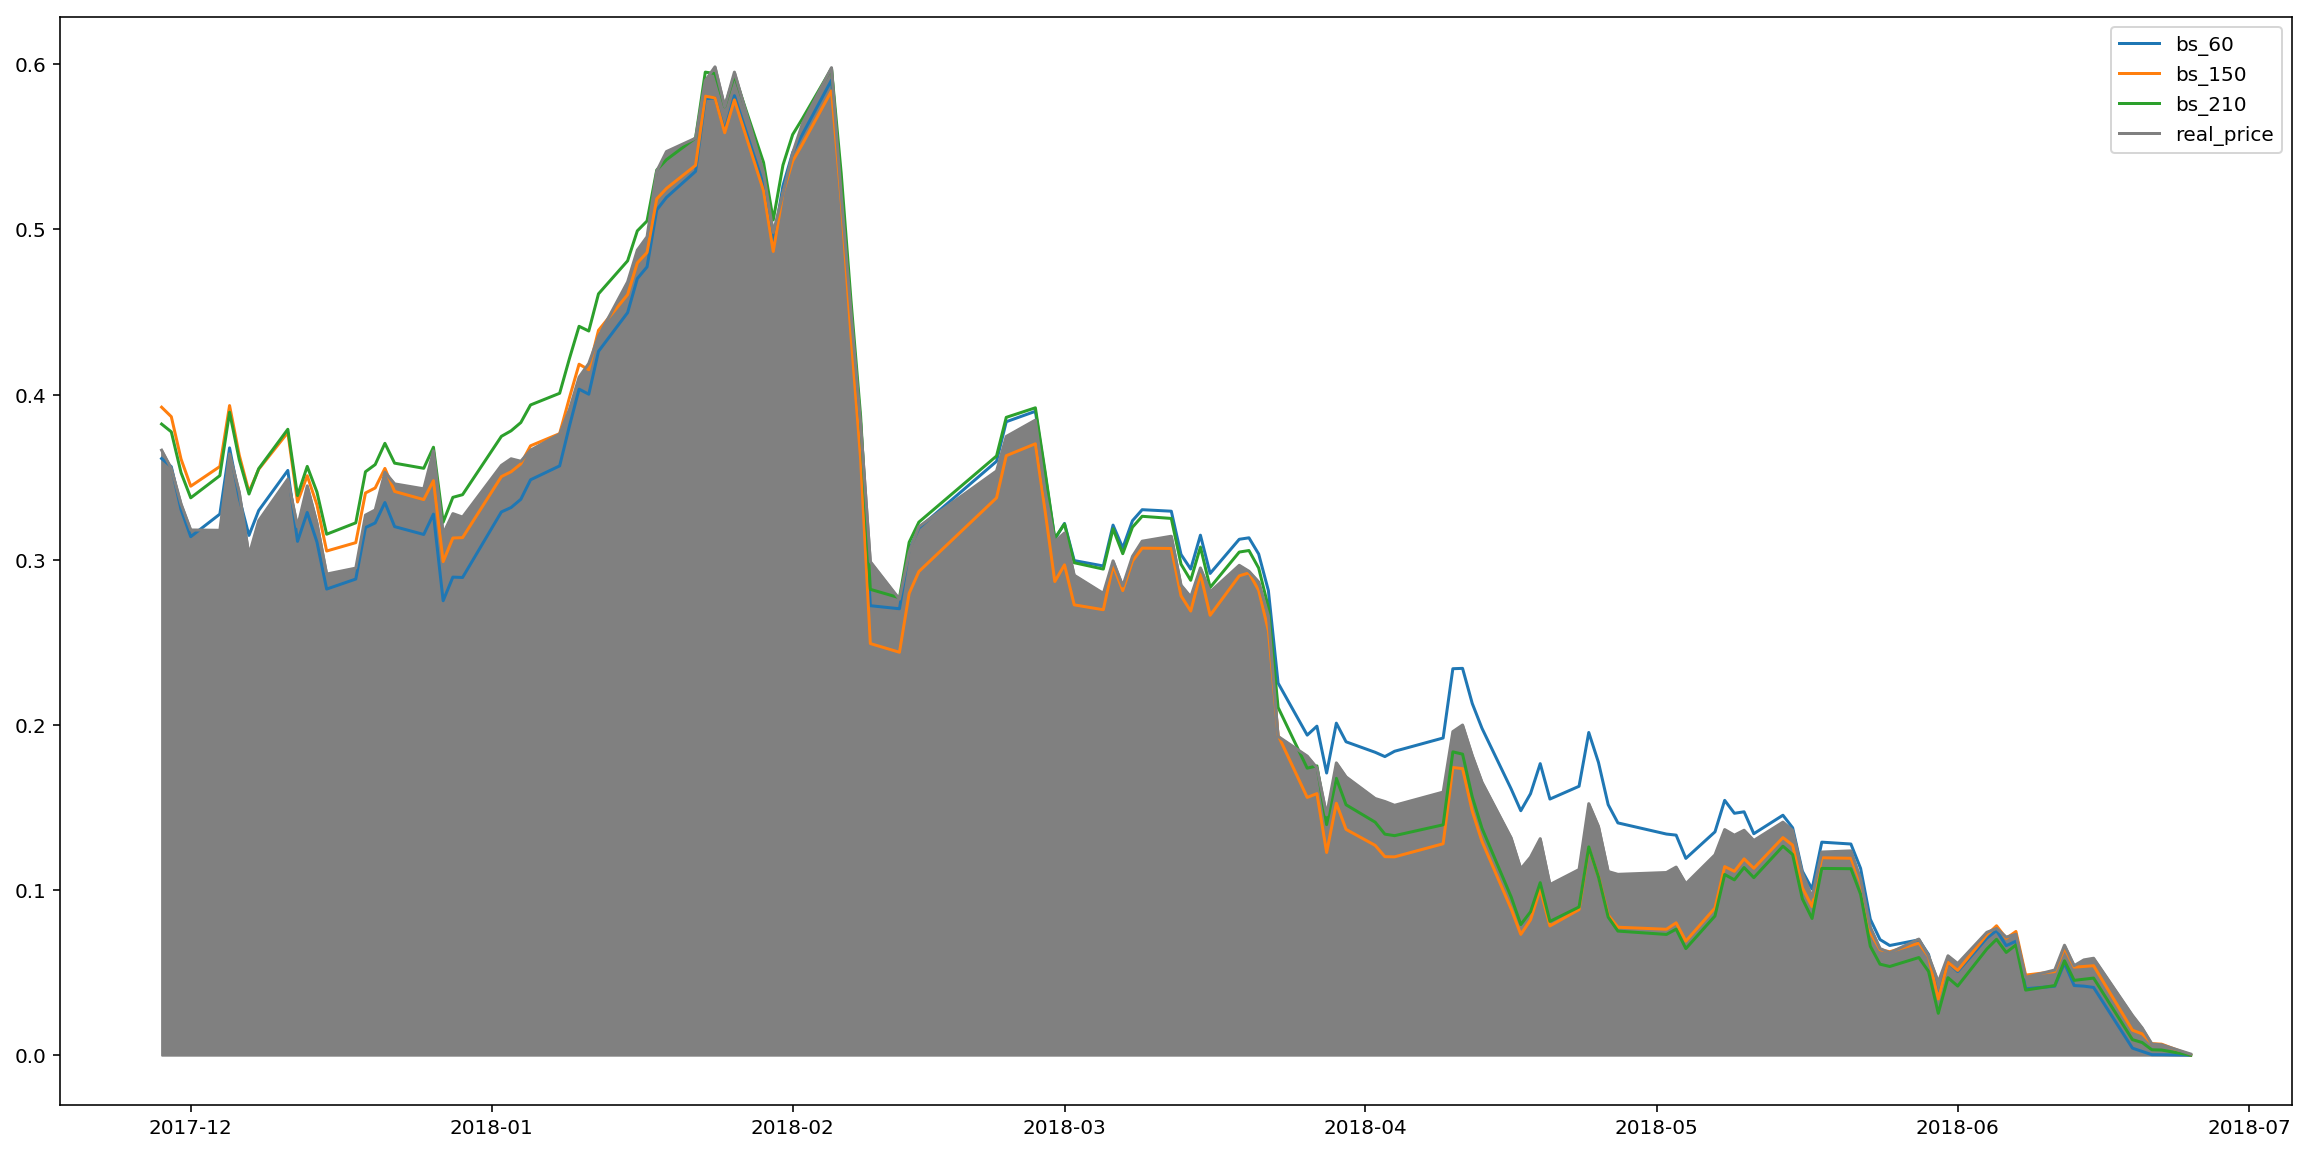

In [20]:
plt.figure(figsize=(20,10))
plt.plot(bs_60, label = 'bs_60')
plt.plot(bs_150,label = 'bs_150')
plt.plot(bs_210,label = 'bs_210')
plt.plot(summary['real_price'], color = 'grey',label = 'real_price')
plt.fill_between( summary.index, summary['real_price'], color = 'grey')
plt.legend()

In [21]:
mean_absolute_percentage_error(summary['real_price'],bs_60)

11.986817952387156

In [22]:
mean_absolute_percentage_error(summary['real_price'],bs_150)

8.90998757652533

In [23]:
mean_absolute_percentage_error(summary['real_price'],bs_210)

11.451880113674726

# EWMA(Exponentially Weighted Moving Average) Vol

## Theory

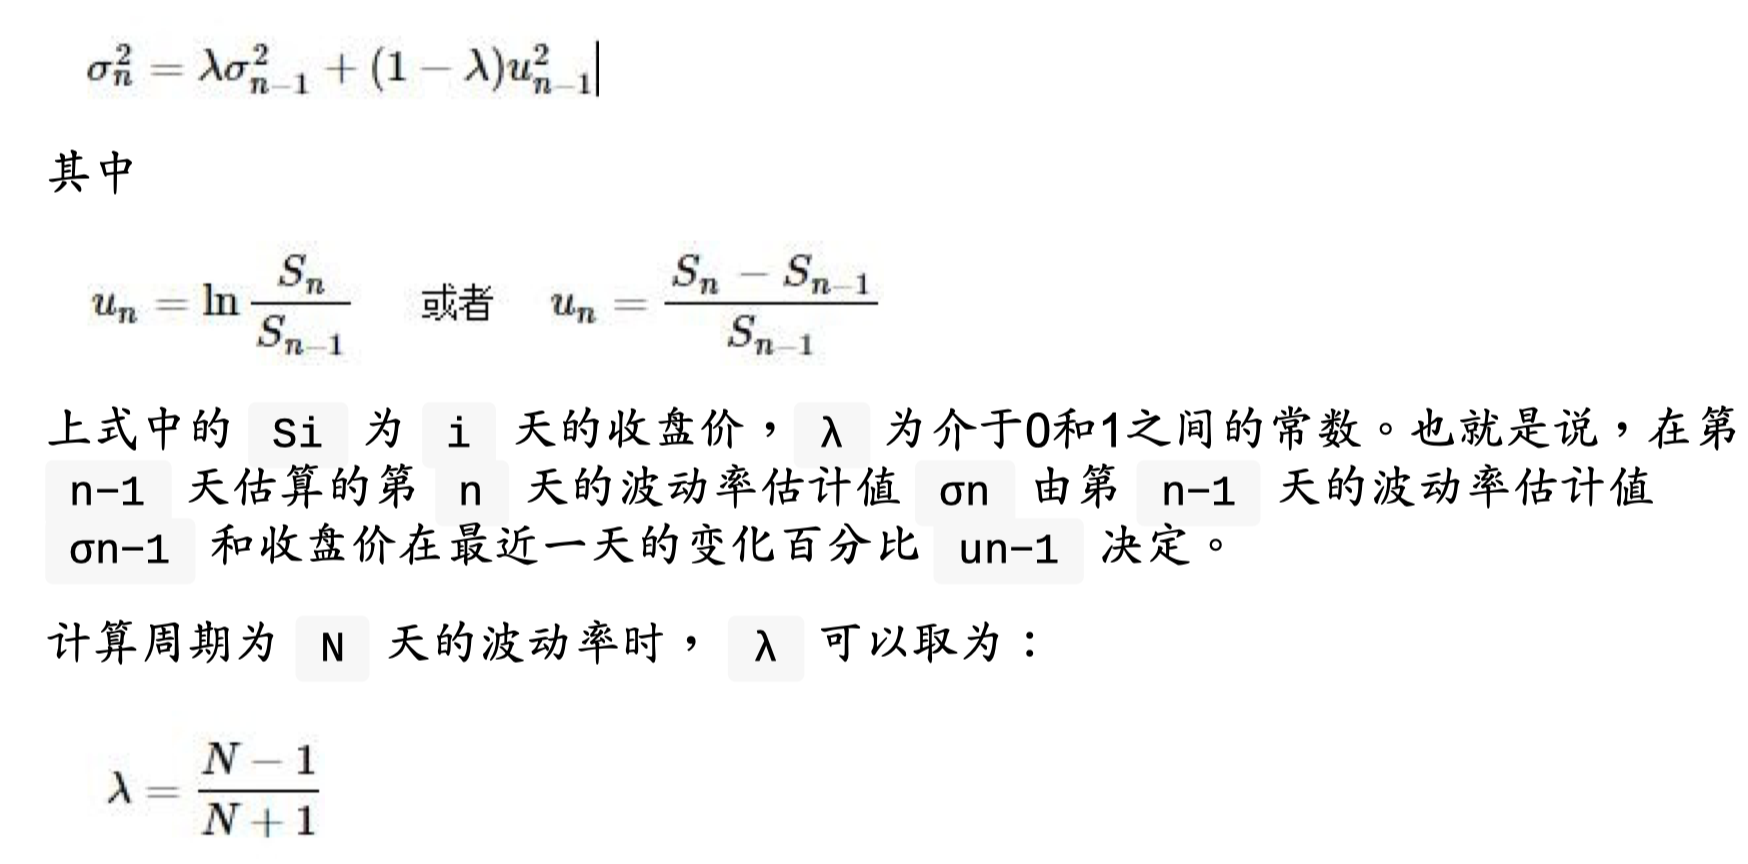

## code

In [24]:
begin_date

'20171026'

In [25]:
import math


def history_ewma_volatility(price_series):
    volatility = pd.DataFrame(index=price_series.index)
    volatility['log_return'] = np.log(price_series) - np.log(
        price_series).shift(1)
    volatility['u2'] = volatility['log_return']**2
    periods = {
        'hv1W': 5,
        'hv2W': 10,
        'hv1M': 21,
        'hv2M': 41,
        'hv3M': 62,
        'hv4M': 83,
        'hv5M': 104,
        'hv6M': 124,
        'hv9M': 186,
        'hv1Y': 249,
        'hv2Y': 497
    }
    for prd in periods.keys():
        volatility[prd] = np.round(
            np.sqrt(pd.ewma(volatility['u2'], span=periods[prd], adjust=False)),
            5) * math.sqrt(252.0)
    return volatility


ewma = history_ewma_volatility(underlying_asset_trade['close'])['20171026':'20180627']
ewma

log_return            u2      hv2M      hv1W      hv1Y      hv3M  \
trade_date                                                                     
2017-10-26    0.008883  7.890113e-05  0.087627  0.095088  0.106677  0.095406   
2017-10-27    0.016141  2.605222e-04  0.102232  0.167000  0.108740  0.104454   
2017-10-30   -0.004186  1.751896e-05  0.100803  0.141759  0.108423  0.103502   
2017-10-31   -0.003501  1.225983e-05  0.099057  0.120011  0.108105  0.102232   
2017-11-01   -0.003162  9.996854e-06  0.097311  0.102232  0.107788  0.100962   
2017-11-02    0.001758  3.089786e-06  0.095247  0.084929  0.107470  0.099533   
2017-11-03    0.001404  1.971221e-06  0.093025  0.070642  0.106994  0.097946   
2017-11-06   -0.002810  7.895972e-06  0.091278  0.063181  0.106677  0.096834   
2017-11-07    0.011193  1.252797e-04  0.097152  0.114773  0.107470  0.100327   
2017-11-08   -0.000348  1.210251e-07  0.094771  0.093818  0.106994  0.098739   
2017-11-09    0.003820  1.459326e-05  0.093501  0.084135  0.106677  0.097787   
2017-11-10    0.011374  1.293576e-04  0.099374  0.124932  0.107470  0.101438   
2017-11-13    0.003421  1.170424e-05  0.097787  0.106677  0.107153  0.100327   
2017-11-14   -0.005136  2.637971e-05  0.096993  0.099057  0.106994  0.099692   
2017-11-15   -0.004128  1.704016e-05  0.095723  0.089215  0.106677  0.098898   
2017-11-16    0.010629  1.129816e-04  0.100486  0.121599  0.107312  0.101756   
2017-11-17    0.019589  3.837134e-04  0.119218  0.205257  0.110487  0.114455   
2017-11-20    0.002005  4.018735e-06  0.116519  0.168587  0.110010  0.112709   
2017-11-21    0.016551  2.739419e-04  0.127314  0.204781  0.112074  0.120488   
2017-11-22    0.006871  4.720557e-05  0.126520  0.178747  0.112074  0.120170   
2017-11-23   -0.025092  6.296138e-04  0.150967  0.272407  0.117154  0.137791   
2017-11-24   -0.000334  1.118182e-07  0.147315  0.222402  0.116678  0.135727   
2017-11-27   -0.008059  6.494980e-05  0.146522  0.196050  0.116836  0.135410   
2017-11-28   -0.023884  5.704344e-04  0.165254  0.271137  0.121122  0.149379   
2017-11-29   -0.002074  4.301362e-06  0.161444  0.222243  0.120805  0.147157   
2017-11-30   -0.011134  1.239754e-04  0.162079  0.208115  0.121281  0.148109   
2017-12-01   -0.007023  4.931552e-05  0.160174  0.181763  0.121281  0.147157   
2017-12-04    0.007023  4.931552e-05  0.158110  0.161761  0.121122  0.146204   
2017-12-05    0.017343  3.007963e-04  0.165571  0.206686  0.123186  0.151919   
2017-12-06   -0.012805  1.639721e-04  0.167635  0.205575  0.123980  0.153824   
2017-12-07   -0.009449  8.928151e-05  0.166841  0.188907  0.124139  0.153665   
2017-12-08    0.007357  5.412307e-05  0.164777  0.168270  0.124139  0.152713   
2017-12-11    0.011452  1.311596e-04  0.165571  0.172873  0.124774  0.153665   
2017-12-12   -0.018106  3.278397e-04  0.173350  0.217957  0.126837  0.159698   
2017-12-13    0.008398  7.051851e-05  0.171603  0.193828  0.126837  0.158904   
2017-12-14   -0.006993  4.890255e-05  0.169222  0.170810  0.126837  0.157634   
2017-12-15   -0.012002  1.440373e-04  0.170333  0.177636  0.127472  0.158745   
2017-12-18    0.004252  1.808214e-05  0.166841  0.150173  0.126996  0.156681   
2017-12-19    0.014742  2.173349e-04  0.170651  0.182398  0.128266  0.159698   
2017-12-20    0.002088  4.361457e-06  0.166682  0.150173  0.127790  0.157316   
2017-12-21    0.005894  3.473436e-05  0.163984  0.133981  0.127631  0.155570   
2017-12-22   -0.005198  2.702354e-05  0.160968  0.119376  0.127314  0.153824   
2017-12-25   -0.000695  4.832594e-07  0.157158  0.097628  0.126679  0.151443   
2017-12-26    0.005894  3.473436e-05  0.154776  0.096358  0.126520  0.149855   
2017-12-27   -0.020605  4.245613e-04  0.167000  0.204622  0.129377  0.158586   
2017-12-28    0.007383  5.450429e-05  0.164936  0.180176  0.129218  0.157475   
2017-12-29    0.001050  1.102996e-06  0.161126  0.147474  0.128742  0.154935   
2018-01-02    0.017000  2.889844e-04  0.167794  0.196844  0.130488  0.159856   
2018-01-03  

In [26]:
periods = {
        'hv1W': 5,
        'hv2W': 10,
        'hv1M': 21,
        'hv2M': 41,
        'hv3M': 62,
        'hv4M': 83,
        'hv5M': 104,
        'hv6M': 124,
        'hv9M': 186,
        'hv1Y': 249,
        'hv2Y': 497
    }

In [27]:
for i in periods.keys():
    print(i)
    print(mean_absolute_percentage_error(ewma[i]['20180110':'20180625'], summary['IV']['20180110':'20180625']))
    print(" ")

hv2M
19.379679026184505
 
hv1W
40.2080778531345
 
hv1Y
36.413748598207015
 
hv3M
18.41533566538245
 
hv4M
19.45035220526527
 
hv5M
21.258162843402314
 
hv2Y
54.18450165199891
 
hv1M
23.690268342465036
 
hv2W
30.518321087588014
 
hv6M
23.2493521666504
 
hv9M
30.051058347761018
 


In [28]:
for i in ['hv1W', 'hv2M', 'hv1Y']:
    print(i)
    print(mean_absolute_percentage_error(ewma[i]['20180110':'20180625'],
                                         summary['IV']['20180110':'20180625']))
    print(" ")

hv1W
40.2080778531345
 
hv2M
19.379679026184505
 
hv1Y
36.413748598207015
 


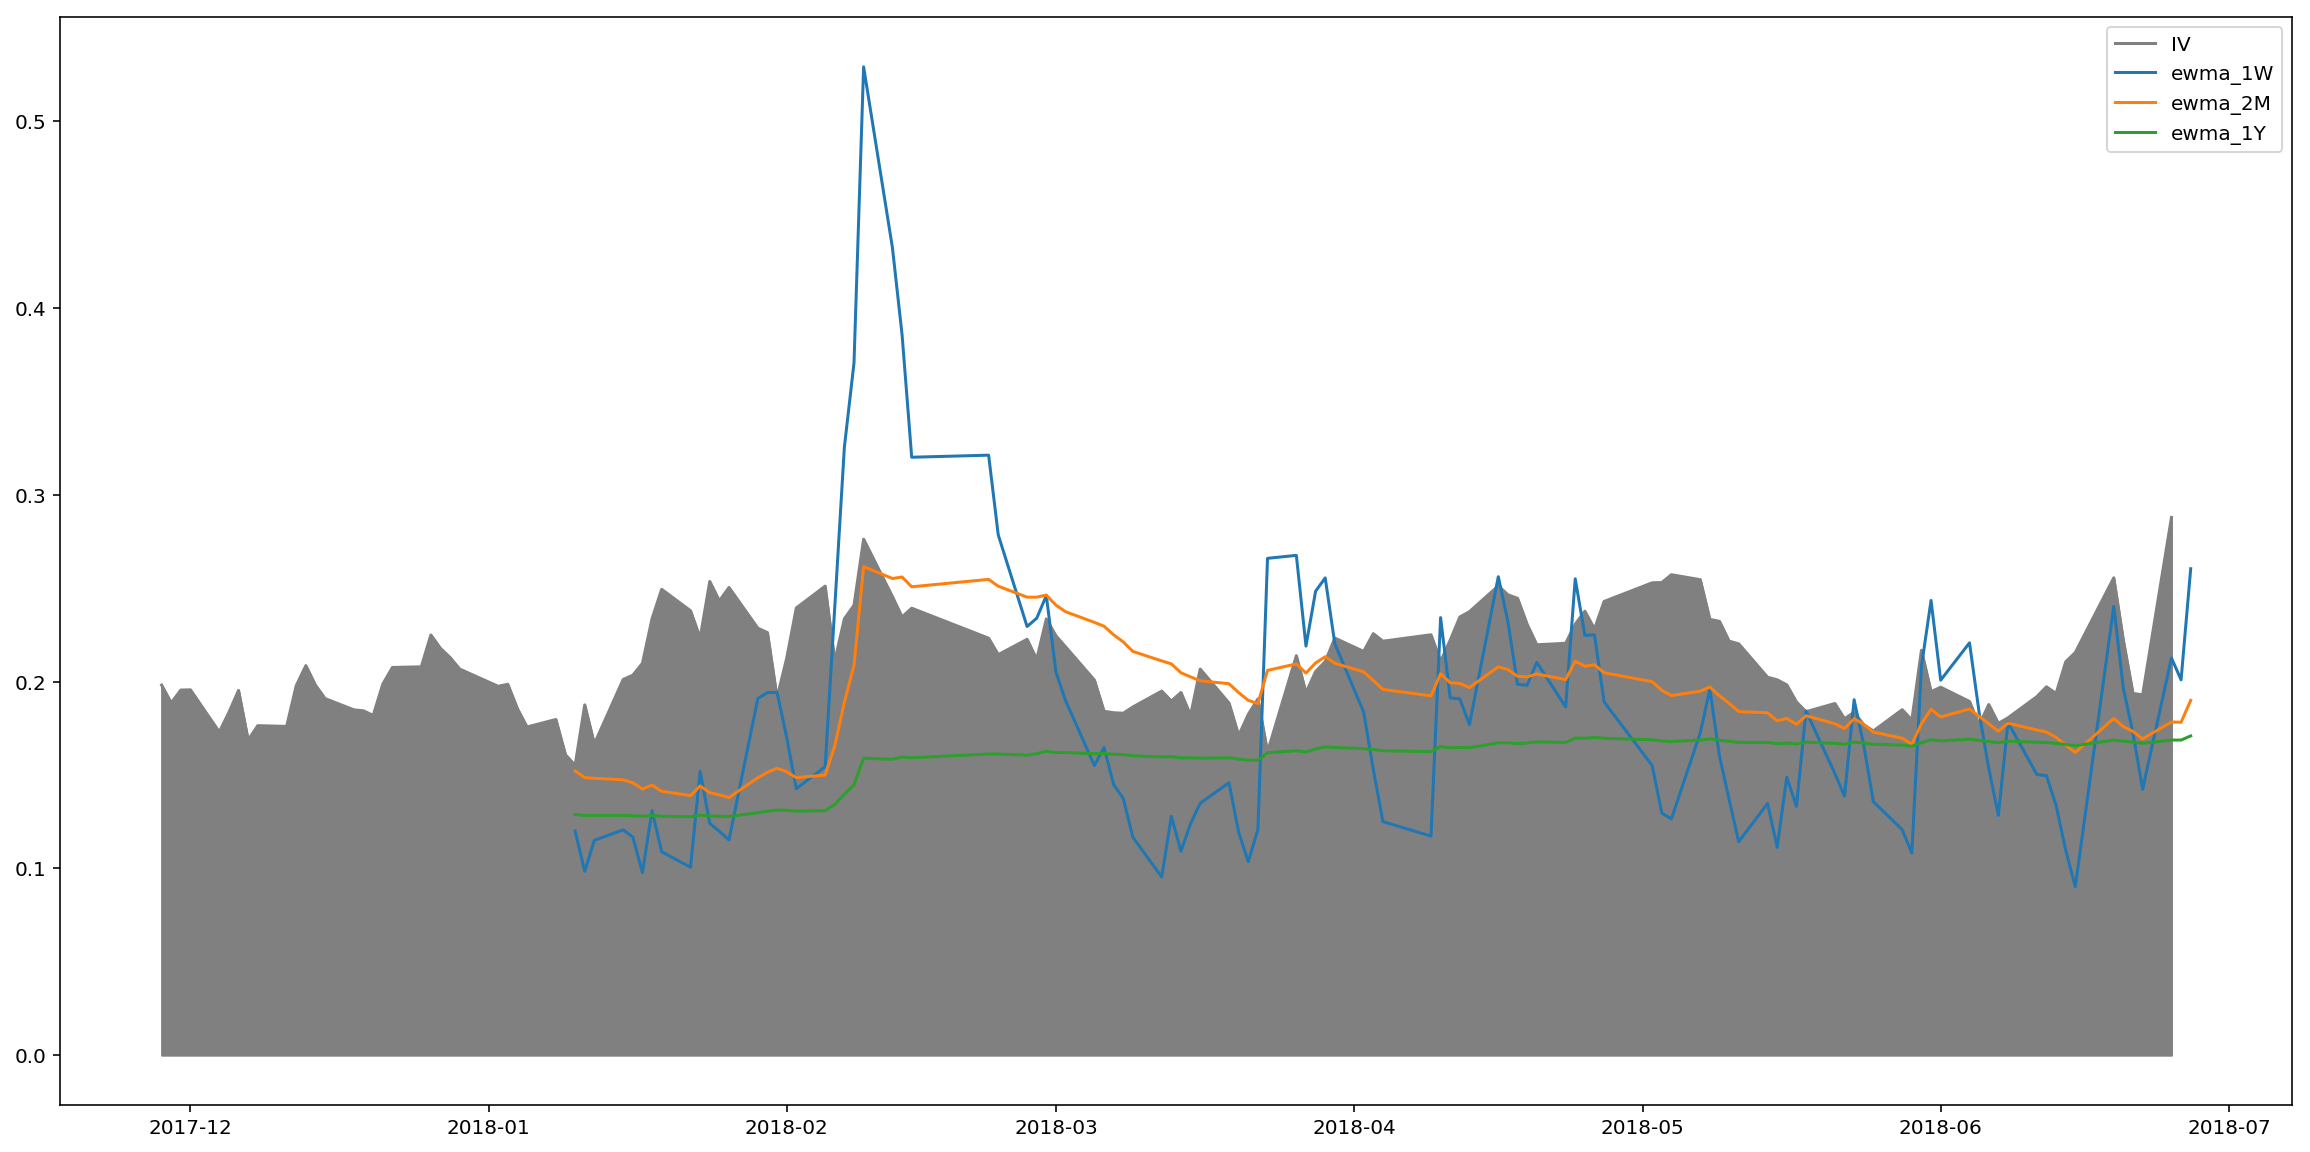

In [29]:
plt.figure(figsize=(20,10))
plt.plot(summary['IV'],color='grey')
plt.fill_between(summary.index, summary['IV'], color='grey')
plt.plot(ewma['20180110':][['hv1W','hv2M','hv1Y']])

plt.legend(['IV','ewma_1W','ewma_2M','ewma_1Y'])

KeyError: 'ewma'

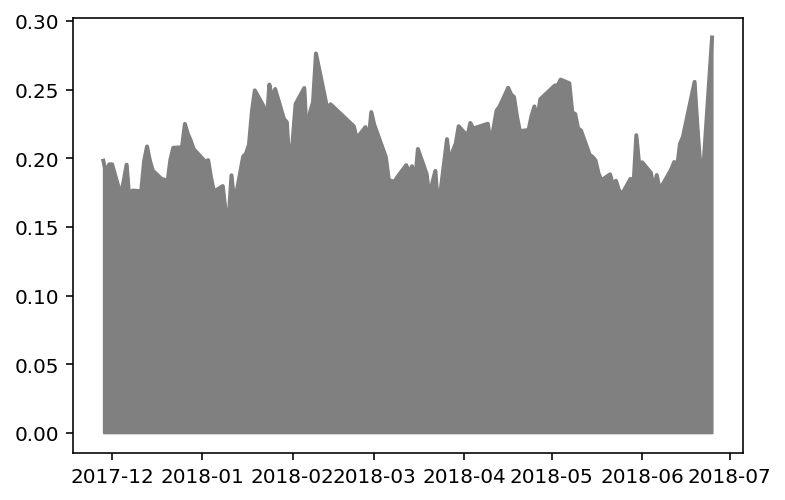

In [30]:
#plt.figure(figsize=(20,10))
plt.plot(summary['IV'], label = 'IV',linewidth=2,color='grey')

def history_ewma_volatility(price_series):
    volatility = pd.DataFrame(index=price_series.index)
    volatility['log_return'] = np.log(price_series) - np.log(
        price_series).shift(1)
    volatility['u2'] = volatility['log_return']**2
    volatility['HV2W'] = np.round(np.sqrt(pd.ewma(volatility['u2'],span=10, adjust=False)), 5)*math.sqrt(252.0)

    return volatility['HV2W']

plt.fill_between(summary.index, summary['IV'], color='grey')
plt.plot(summary['ewma'], label = 'ewma')
plt.plot(summary['HV75'], label = 'HV75')

plt.legend()

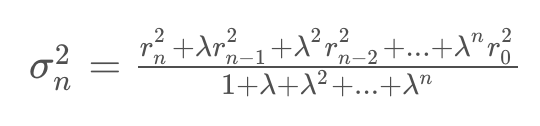

0.01


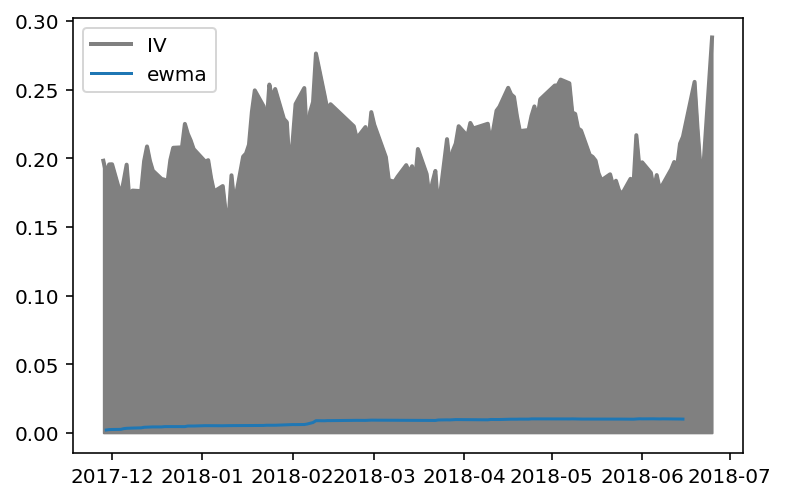

0.2


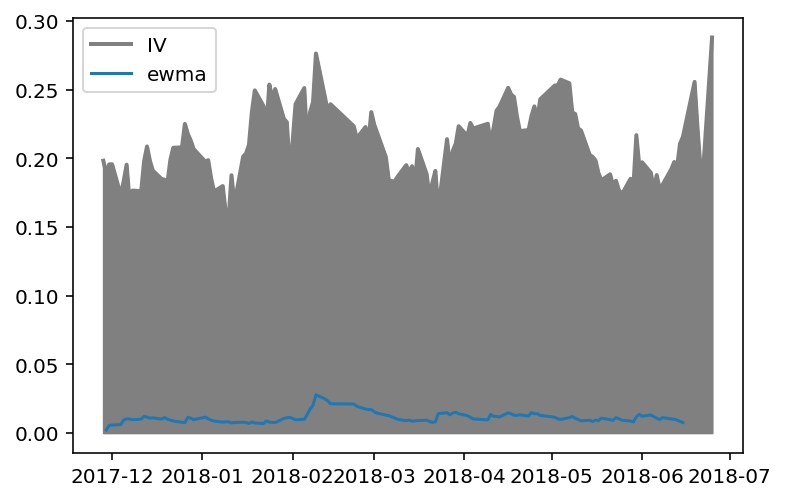

0.4


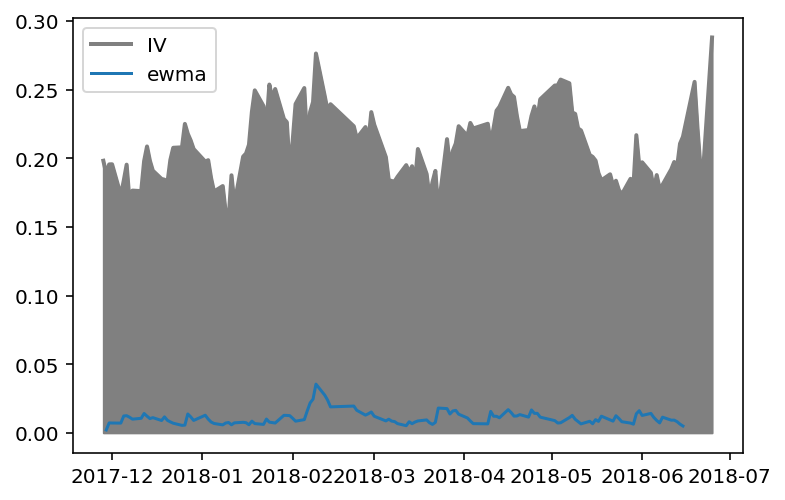

0.6


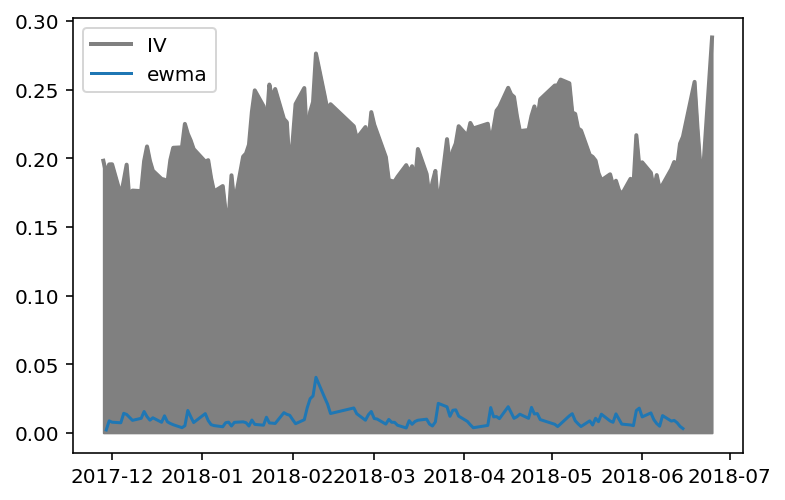

0.8


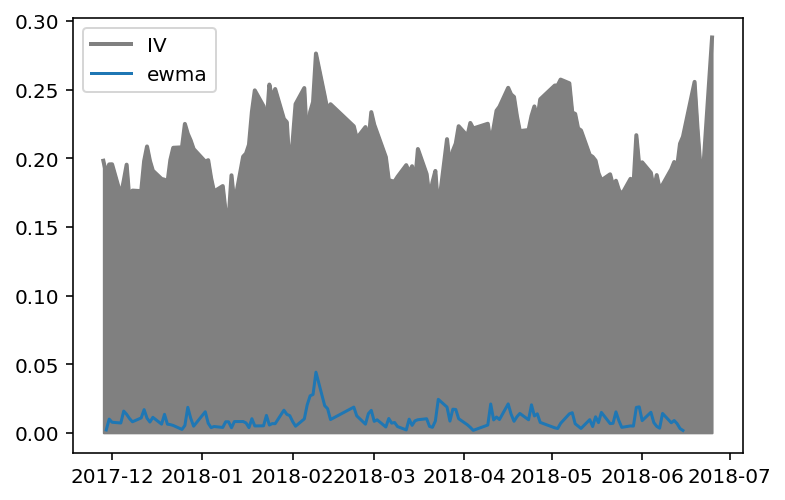

1


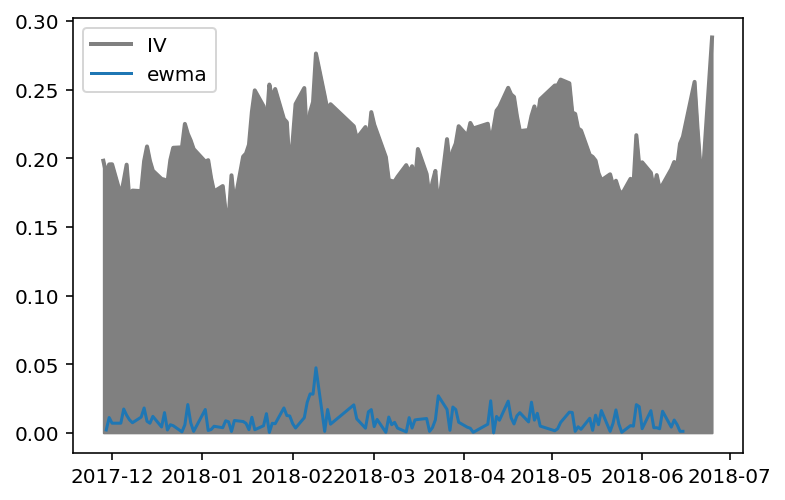

In [31]:
def history_ewma_volatility_alpha(price_series, alpha):
    volatility = pd.DataFrame(index=price_series.index)
    volatility['log_return'] = np.log(price_series) - np.log(
        price_series).shift(1)
    volatility['u2'] = volatility['log_return']**2
    #volatility['HV2W'] = np.round(np.sqrt(pd.ewma(volatility['u2'],span=10, adjust=False)), 5)*math.sqrt(252.0)
    
    #return volatility['HV2W']
    return np.sqrt(volatility['u2'].ewm(alpha=alpha,adjust=False).mean())
    #return np.sqrt(pd.ewma(volatility['u2'], )
    #    volatility['u2'].ewm(alpha=alpha).mean())

#plt.figure(figsize=(20,10))
for i in [0.01,0.2,.4,.6,.8,1]:
    print(i)
    plt.plot(summary['IV'], label = 'IV',linewidth=2,color='grey')
    plt.fill_between(summary.index, summary['IV'], color='grey')
    plt.plot(history_ewma_volatility_alpha(summary['s'],i)[:-5], label = 'ewma')
#    plt.plot(summary['HV75'], label = 'HV75')
    plt.legend()
    plt.show()

In [32]:
summary['history_vol_30'] = history_volatility(underlying_asset_trade['close'], 75) 
summary = summary.iloc[1:,]
plt.plot(summary['IV_2'], label = 'IV_2')
plt.plot(summary['history_vol_30'], label = 'sigma')
plt.plot(summary['ewma'], label = 'sigma')

plt.legend()

KeyError: 'IV_2'

In [ ]:
plt.figure(figsize=(20,12))
plt.plot(summary.IV, label = "IV")
plt.plot(summary.HV90, label = 'HV90')
plt.plot(ewma['20171001':], label='ewma')
plt.legend()

#  GARCH


In [33]:
import arch

In [34]:
summary['log_return'] = np.log(summary['real_price']) - np.log(summary['real_price'].shift(1))
data = np.array(summary['log_return'].dropna())[:-1]

data

array([-6.21389999e-02, -4.84906284e-02, -6.29128678e-04,  1.36006301e-01,
       -6.61327602e-02, -1.18553579e-01,  6.67659692e-02,  7.49905069e-02,
       -8.64902451e-02,  7.46660266e-02, -6.75020028e-02, -1.00818807e-01,
        1.22826519e-02,  1.03323855e-01,  9.43546796e-03,  6.70724181e-02,
       -2.03183410e-02, -8.71085647e-03,  6.49212126e-02, -1.47567676e-01,
        3.79162883e-02, -6.42498768e-03,  9.17321584e-02,  1.11390737e-02,
       -4.16262569e-03,  1.84603672e-02,  2.61364736e-02,  3.88626294e-02,
        4.89241561e-02,  2.00175501e-02,  3.84122165e-02,  7.30898595e-02,
        4.01895861e-02,  1.64822126e-02,  7.70731550e-02,  2.19910923e-02,
        1.46968081e-02,  6.07941277e-02,  1.41368898e-02, -4.11075188e-02,
        3.57455756e-02, -1.07565753e-01, -7.05308704e-02,  4.62918499e-02,
        4.60755654e-02,  3.18859761e-02,  5.83692644e-02, -1.37289671e-01,
       -1.45553817e-01, -1.63328636e-01, -2.47476939e-01, -7.90113343e-02,
        9.79079682e-02,  

In [35]:
train = data[:-10]
test = data[-10:]
am = arch.arch_model(train,mean='AR',lags=8,vol='GARCH') 
res = am.fit()

Iteration:      1,   Func. Count:     14,   Neg. LLF: -97.9452852204
Iteration:      2,   Func. Count:     33,   Neg. LLF: -98.4452382116
Iteration:      3,   Func. Count:     53,   Neg. LLF: -98.9406858923
Iteration:      4,   Func. Count:     70,   Neg. LLF: -100.110656507
Iteration:      5,   Func. Count:     87,   Neg. LLF: -100.19826281
Iteration:      6,   Func. Count:    103,   Neg. LLF: -100.733961898
Iteration:      7,   Func. Count:    119,   Neg. LLF: -101.005438108
Iteration:      8,   Func. Count:    135,   Neg. LLF: -101.018652157
Iteration:      9,   Func. Count:    150,   Neg. LLF: -101.030837994
Iteration:     10,   Func. Count:    165,   Neg. LLF: -101.123851009
Iteration:     11,   Func. Count:    181,   Neg. LLF: -101.175331871
Iteration:     12,   Func. Count:    197,   Neg. LLF: -101.246893733
Iteration:     13,   Func. Count:    213,   Neg. LLF: -101.254241257
Iteration:     14,   Func. Count:    227,   Neg. LLF: -101.58906354
Iteration:     15,   Func. Count:   

In [36]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.005
Mean Model:                        AR   Adj. R-squared:                 -0.079
Vol Model:                      GARCH   Log-Likelihood:                101.720
Distribution:                  Normal   AIC:                          -179.440
Method:            Maximum Likelihood   BIC:                          -146.192
                                        No. Observations:                  118
Date:                Tue, Apr 16 2019   Df Residuals:                      106
Time:                        19:42:50   Df Model:                           12
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -7.0103e-03  8.627e-03     -0.813      0.416 [-2.392e-02,9.898e-03]
y[1]            0.1903      0.107      1.779  7.525e-02   [-1.937e-02,  0.400]
y[2]           -0.0767      0.111     -0.692      0.489      [ -0.294,  0.140]
y[3]            0.1195      0.105      1.142      0.253   [-8.559e-02,  0.325]
y[4]           -0.1854      0.113     -1.645  9.993e-02    [ -0.406,3.547e-02]
y[5]           -0.0586  9.879e-02     -0.593      0.553      [ -0.252,  0.135]
y[6]            0.0142      0.105      0.135      0.893      [ -0.192,  0.220]
y[7]           -0.0177  9.582e-02     -0.185      0.854      [ -0.205,  0.170]
y[8]            0.1087      0.103      1.050      0.294   [-9.414e-02,  0.312]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.6947e-04  3.164e-04      0.536      0.592 [-4.506e-04,7.896e-04]
alpha[1]       0.0686  3.609e-02      1.902  5.723e-02   [-2.107e-03,  0.139]
beta[1]        0.9314  5.198e-02     17.919  8.330e-72      [  0.830,  1.033]
=============================================================================

Covariance estimator: robust
"""

In [37]:
res.params

Const      -0.007010
y[1]        0.190330
y[2]       -0.076704
y[3]        0.119510
y[4]       -0.185369
y[5]       -0.058580
y[6]        0.014202
y[7]       -0.017680
y[8]        0.108699
omega       0.000169
alpha[1]    0.068623
beta[1]     0.931377
Name: params, dtype: float64

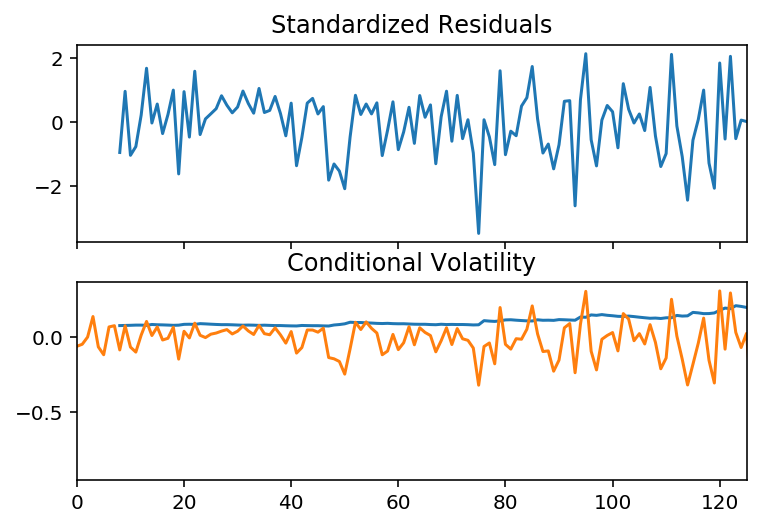

In [38]:
res.plot()
plt.plot(data)

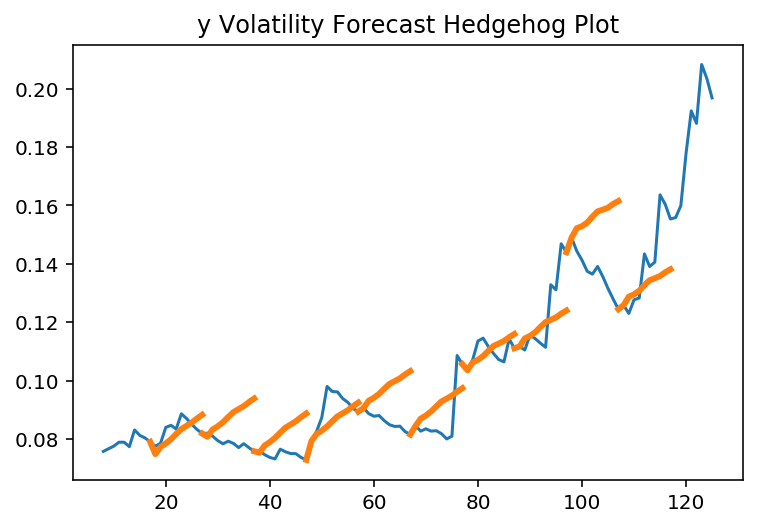

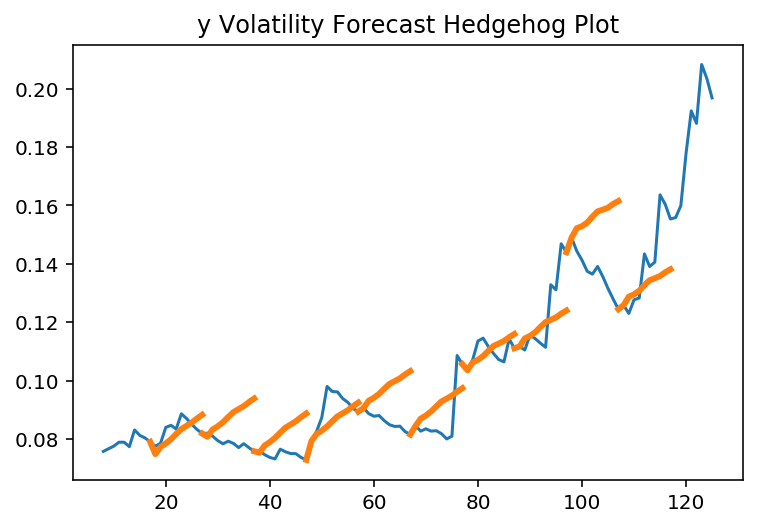

In [39]:
res.hedgehog_plot()

In [40]:
res.params

Const      -0.007010
y[1]        0.190330
y[2]       -0.076704
y[3]        0.119510
y[4]       -0.185369
y[5]       -0.058580
y[6]        0.014202
y[7]       -0.017680
y[8]        0.108699
omega       0.000169
alpha[1]    0.068623
beta[1]     0.931377
Name: params, dtype: float64

In [41]:
ini = res.resid[-8:]
a = np.array(res.params[1:9])
w = a[::-1] # 系数
for i in range(10):
    new = test[i] - (res.params[0] + w.dot(ini[-8:]))
    ini = np.append(ini,new)
print len(ini)
at_pre = ini[-10:]
at_pre2 = at_pre**2
at_pre2

18


array([1.17916537e-01, 4.33571869e-02, 2.20766078e-02, 2.23775786e-02,
       5.32260556e-04, 8.96579383e-04, 6.87819772e-01, 5.62695988e-02,
       7.66700512e-01, 2.70703679e-02])

In [42]:
ini2 = res.conditional_volatility[-2:] #上两个条件异方差值

for i in range(10):
    new = 0.000280 + 0.075702*at_pre2[i] + 0.924298*ini2[-1] #
    ini2 = np.append(ini2,new)
vol_pre = ini2[-10:]
vol_pre

array([0.19109282, 0.18018893, 0.16849951, 0.15771779, 0.14609853,
       0.13538645, 0.17748676, 0.16859038, 0.21414851, 0.20026632])

In [43]:
len(train)

126

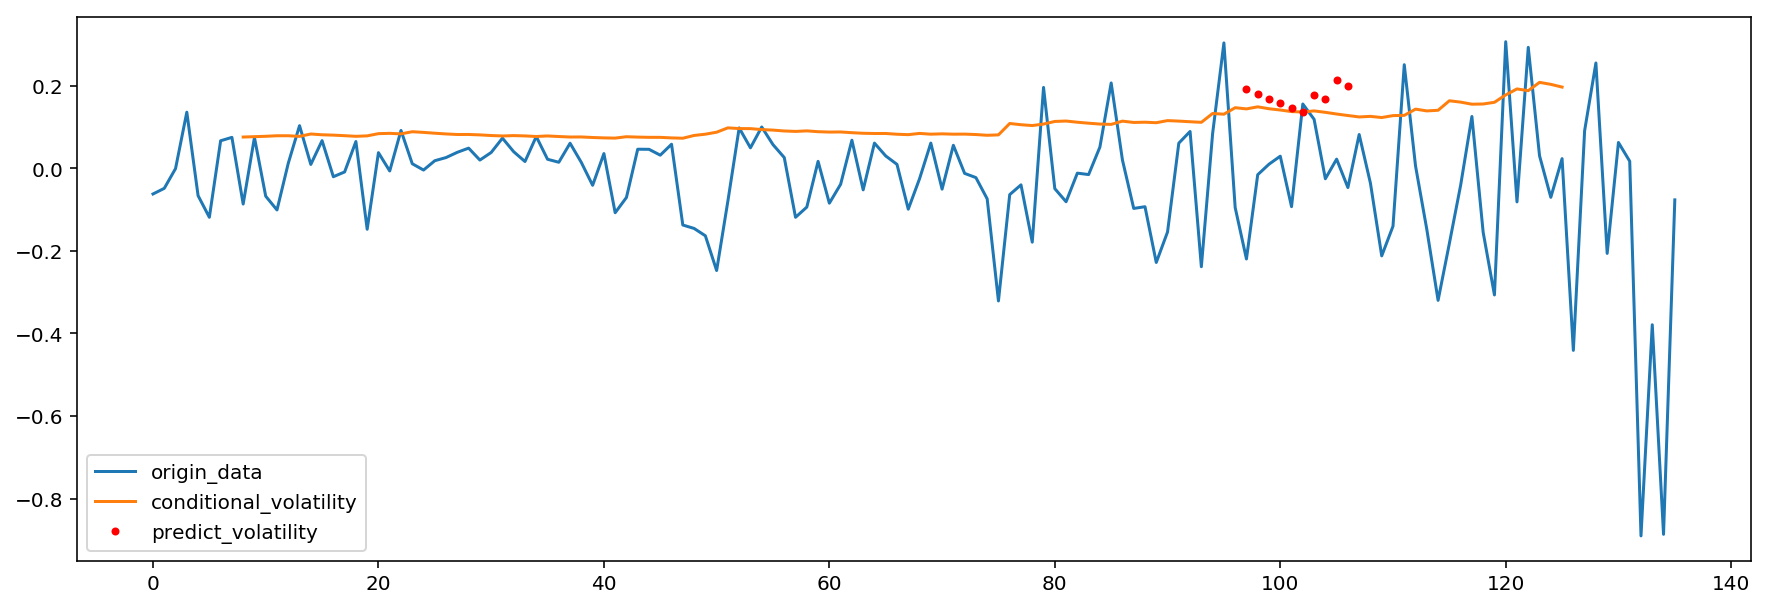

In [44]:
plt.figure(figsize=(15,5))
plt.plot(data,label='origin_data')
plt.plot(res.conditional_volatility,label='conditional_volatility')
x=range(97,107)
plt.plot(x,vol_pre,'.r',label='predict_volatility')
plt.legend(loc=0)

In [45]:
model=arch_model(summary['log_return'], vol='Garch', p=1, o=0, q=1, dist='Normal')
results=model.fit()
print(results.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: nan
Iteration:      2,   Func. Count:     22,   Neg. LLF: nan
Iteration:      3,   Func. Count:     38,   Neg. LLF: nan
Iteration:      4,   Func. Count:     54,   Neg. LLF: nan
Iteration:      5,   Func. Count:     70,   Neg. LLF: nan
Iteration:      6,   Func. Count:     86,   Neg. LLF: nan
Iteration:      7,   Func. Count:    102,   Neg. LLF: nan
Iteration:      8,   Func. Count:    118,   Neg. LLF: nan
Iteration:      9,   Func. Count:    134,   Neg. LLF: nan
Iteration:     10,   Func. Count:    150,   Neg. LLF: nan
Iteration:     11,   Func. Count:    166,   Neg. LLF: nan
Iteration:     12,   Func. Count:    182,   Neg. LLF: nan
Iteration:     13,   Func. Count:    198,   Neg. LLF: nan
Iteration:     14,   Func. Count:    214,   Neg. LLF: nan
Iteration:     15,   Func. Count:    230,   Neg. LLF: nan
Iteration:     16,   Func. Count:    246,   Neg. LLF: nan
Iteration:     17,   Func. Count:    262,   Neg. LLF: nan
Iteration:    

/Users/joyjigsaw/anaconda3/envs/python3/lib/python2.7/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [46]:
results.plot(annualize='D')

ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function post_execute at 0x11cdd79b0> (for post_execute):


ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -0.001 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

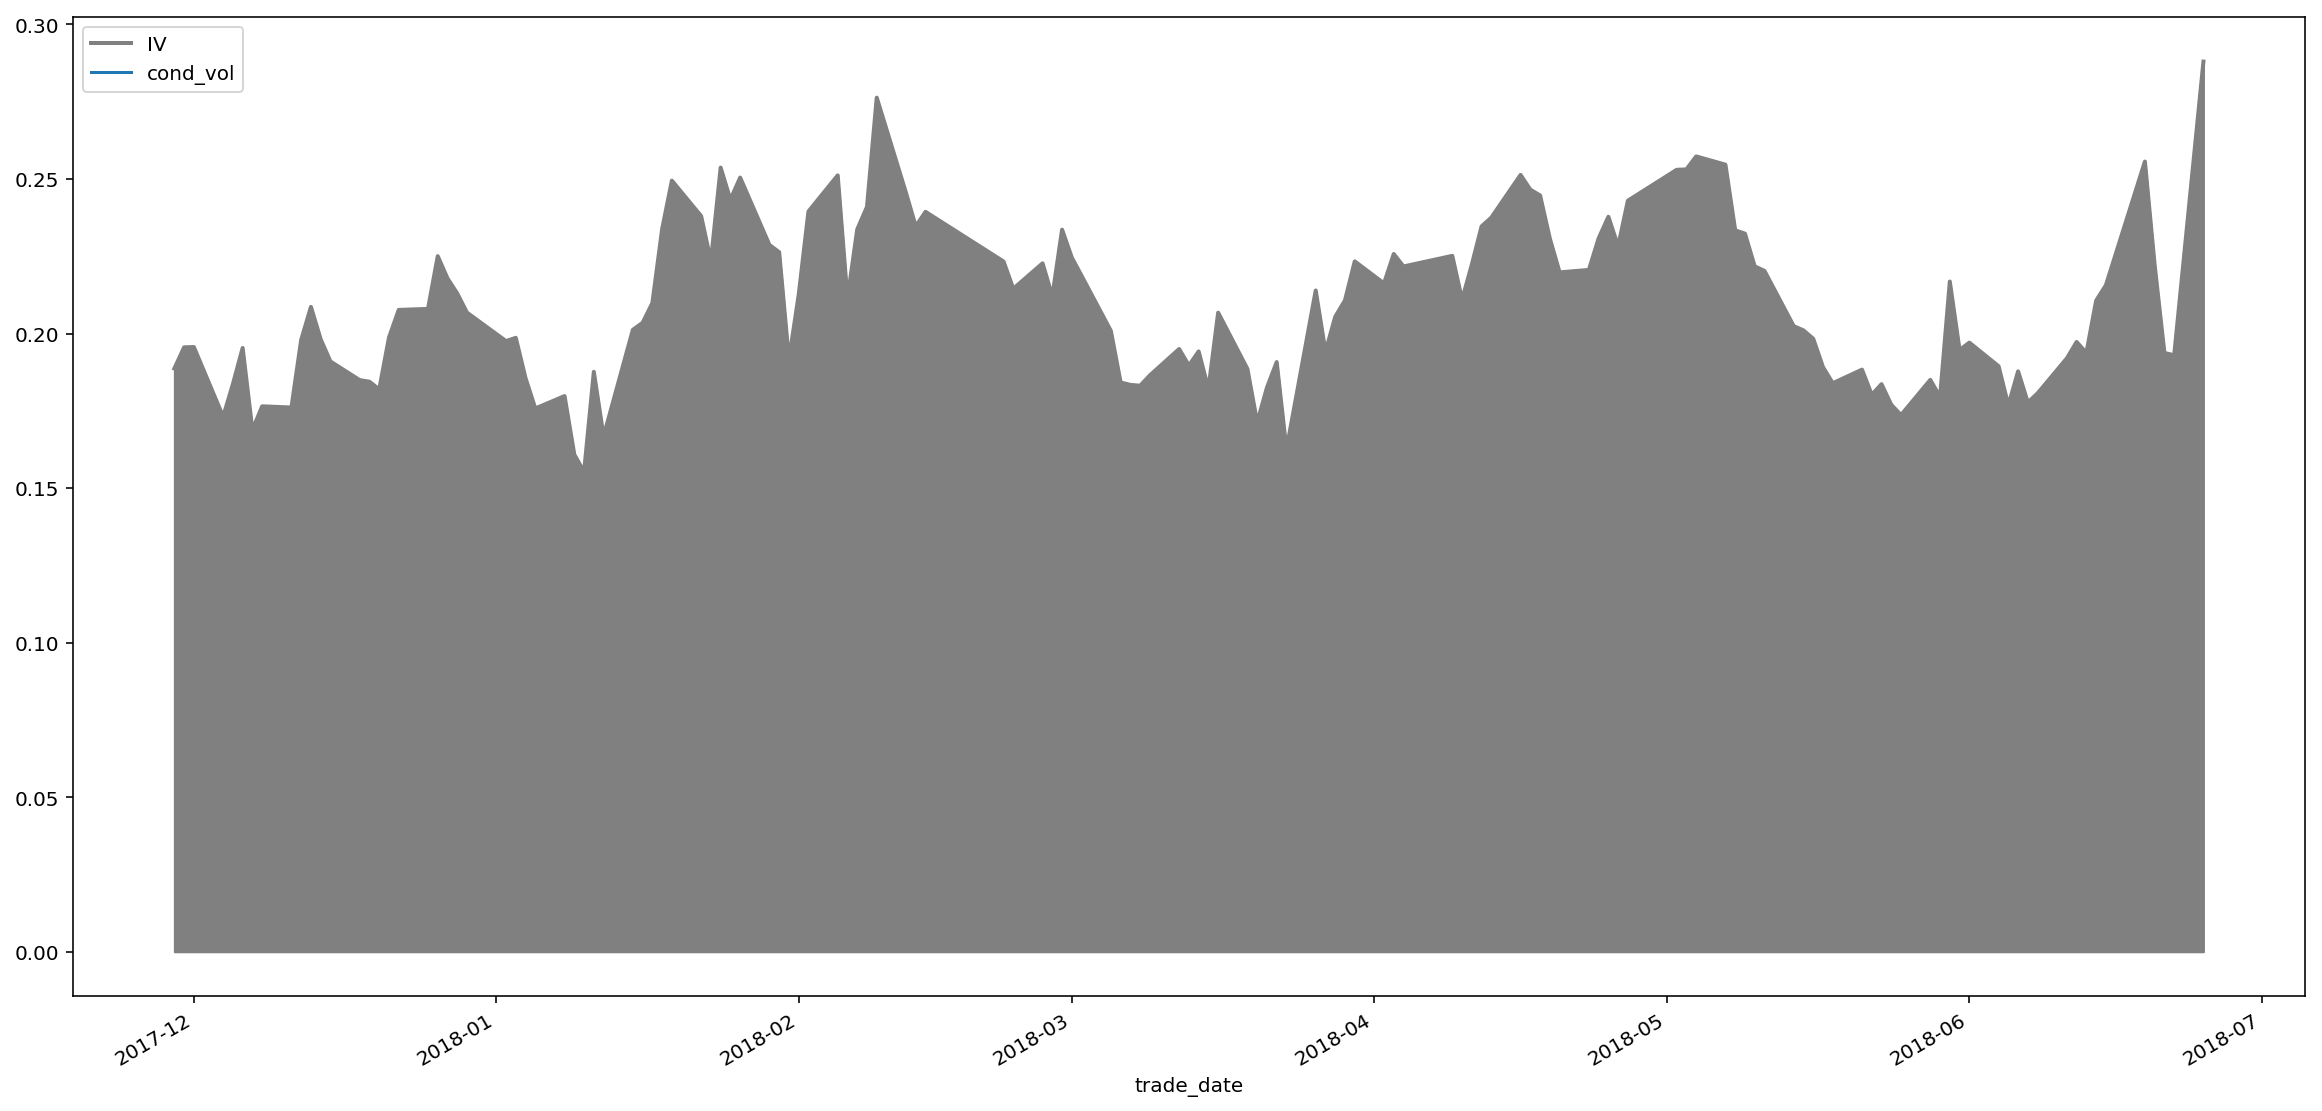

In [47]:
plt.figure(figsize=(20,10))
plt.plot(summary['IV'], label = 'IV',linewidth=2,color='grey')
plt.fill_between(summary.index, summary['IV'], color='grey')
results.conditional_volatility.plot()

plt.legend()

In [48]:
mean_absolute_percentage_error(results.conditional_volatility,summary['IV'])

nan

In [49]:
train = data[:-10]
test = data[-10:]
am = arch.arch_model(train,mean='AR',lags=8,vol='GARCH') 
res = am.fit()

Iteration:      1,   Func. Count:     14,   Neg. LLF: -97.9452852204
Iteration:      2,   Func. Count:     33,   Neg. LLF: -98.4452382116
Iteration:      3,   Func. Count:     53,   Neg. LLF: -98.9406858923
Iteration:      4,   Func. Count:     70,   Neg. LLF: -100.110656507
Iteration:      5,   Func. Count:     87,   Neg. LLF: -100.19826281
Iteration:      6,   Func. Count:    103,   Neg. LLF: -100.733961898
Iteration:      7,   Func. Count:    119,   Neg. LLF: -101.005438108
Iteration:      8,   Func. Count:    135,   Neg. LLF: -101.018652157
Iteration:      9,   Func. Count:    150,   Neg. LLF: -101.030837994
Iteration:     10,   Func. Count:    165,   Neg. LLF: -101.123851009
Iteration:     11,   Func. Count:    181,   Neg. LLF: -101.175331871
Iteration:     12,   Func. Count:    197,   Neg. LLF: -101.246893733
Iteration:     13,   Func. Count:    213,   Neg. LLF: -101.254241257
Iteration:     14,   Func. Count:    227,   Neg. LLF: -101.58906354
Iteration:     15,   Func. Count:   